In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, tensorflow as tf
import sys, time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, MaxPooling1D, GlobalAveragePooling1D, Conv1DTranspose, LSTM, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

2024-03-26 13:39:45.317173: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-26 13:39:45.317199: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-26 13:39:45.318056: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-26 13:39:45.323543: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-26 13:39:46.049390: W tensorflow/compiler/tf2

In [2]:
from tensorflow.keras import backend as K

def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

In [22]:
MODEL = 0 # 0 = th v air, 1 = el v sky

In [23]:
index = [0,3] if MODEL==0 else [1,2]
model_name = 'th_v_air' if MODEL==0 else 'el_v_sky'

base_data_train, base_data_test = np.load('../../data/training_data/training_data_1month.npy', allow_pickle=True)

vae_data_train = np.load(f'../../data/vae_synthetic_data/{model_name}_generated_samples.npy')
vae_data_train_rescaled = np.load(f'../../data/vae_synthetic_data/{model_name}_rescaled_samples.npy')

gan_data_train = np.load(f'../../data/gan_synthetic_data/{model_name}_generated_samples.npy')
gan_data_train_rescaled = np.load(f'../../data/gan_synthetic_data/{model_name}_rescaled_samples.npy')

base_data_train, base_data_test, vae_data_train = base_data_train[:,:,index], base_data_test[:,:,index], vae_data_train[:,:,[0,1]]
print(base_data_train.shape,vae_data_train.shape,gan_data_train.shape)

(108, 730, 2) (1000, 730, 2) (1000, 730, 2)


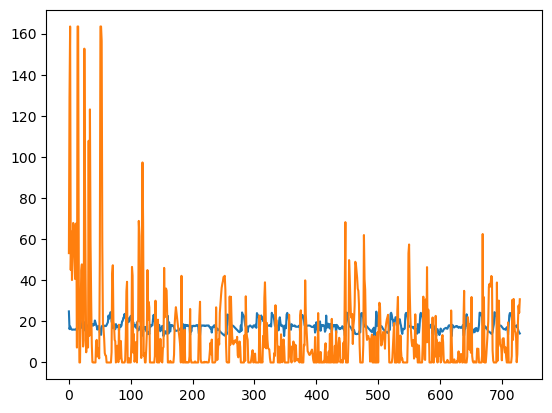

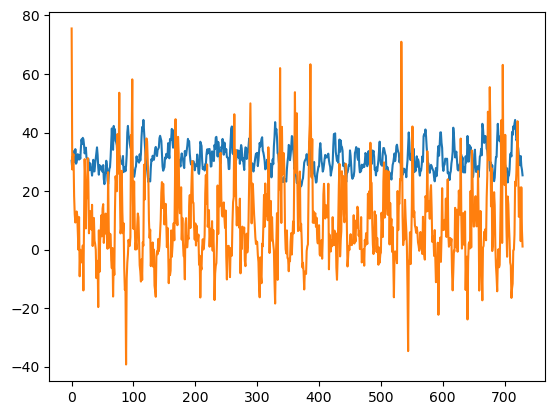

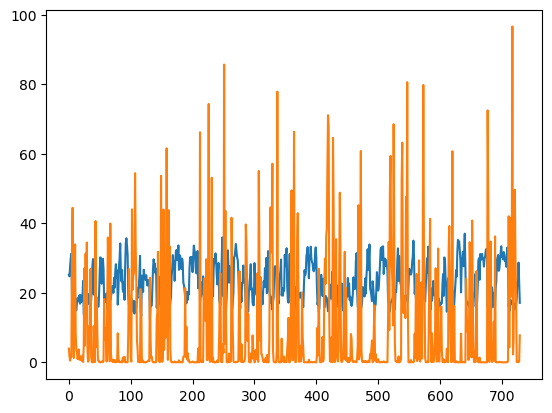

In [24]:
plt.plot(base_data_train[0])
plt.show()
plt.plot(vae_data_train_rescaled[200])
plt.show()
plt.plot(gan_data_train_rescaled[200])
plt.show()

In [25]:
'''def create_cnn(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(input_shape)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(730, activation='linear') #Dense(1)
    ])
    return model

def create_cnn(input_length):
    model = Sequential([
        Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(input_length, 1)),
        Dropout(0.5),
        LSTM(32, return_sequences=True),
        GlobalAveragePooling1D(),
        Dense(50, activation='relu'),
        Dense(730, activation='linear')  # Output layer for regression
    ])
    return model'''

"def create_cnn(input_shape):\n    model = Sequential([\n        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(input_shape)),\n        MaxPooling1D(pool_size=2),\n        Flatten(),\n        Dense(50, activation='relu'),\n        Dense(730, activation='linear') #Dense(1)\n    ])\n    return model\n\ndef create_cnn(input_length):\n    model = Sequential([\n        Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(input_length, 1)),\n        Dropout(0.5),\n        LSTM(32, return_sequences=True),\n        GlobalAveragePooling1D(),\n        Dense(50, activation='relu'),\n        Dense(730, activation='linear')  # Output layer for regression\n    ])\n    return model"

In [26]:
def create_cnn(input_shape):
    model = Sequential([
        Conv1D(filters=32, kernel_size=24, activation='relu', input_shape=(input_shape)),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),
        Conv1D(filters=64, kernel_size=24, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(730, activation='linear')
    ])
    return model

In [27]:
print(base_data_train[:,:,0].shape)

(108, 730)


In [28]:
def test_cnn(training_data):
    X_train = training_data[:,:,0].reshape(-1,730,1)
    y_train = training_data[:,:,1]

    X_test = scaled_data_test[:,:,0].reshape(-1, 730, 1)  
    y_test = scaled_data_test[:,:,1]

    X_train, X_train_val, y_train, y_train_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)
                                                                  
    model = create_cnn((X_train.shape[1], X_train.shape[2]))
    model.compile(optimizer=Adam(), loss='mse', metrics=['mse', 'mae', 'accuracy'])

    early_stopping = EarlyStopping(monitor='mse', patience=10, verbose=1, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='mse', factor=0.5, patience=5, verbose=1)
    model.fit(X_train, y_train, epochs=100, batch_size=16, callbacks=[early_stopping, reduce_lr], verbose=1, validation_data=(X_train_val, y_train_val))

    loss, mse, mae, accuracy = model.evaluate(X_test, y_test)
    r2 = r_squared(tf.convert_to_tensor(y_test, dtype=tf.float32), tf.convert_to_tensor(model.predict(X_test), dtype=tf.float32))
    
    return {'mse':mse, 'mae':mae, 'r2':r2.numpy(), 'acc':accuracy}


<h3> Scaling data before evaluation </h3>

Scale base dataset and use the scaled vae dataset

In [29]:
from sklearn.preprocessing import MinMaxScaler

scalers = {var_name: MinMaxScaler(feature_range=(-1,1)) for var_name in ['G.air.T', 'G.E_th_I']}

temp_var, energy_var = base_data_train[:,:,0], base_data_train[:,:,1]
temp_var_test, energy_var_test = base_data_test[:,:,0], base_data_test[:,:,1]

temp_var, temp_var_test = scalers['G.air.T'].fit_transform(temp_var), scalers['G.air.T'].fit_transform(temp_var_test)
energy_var, energy_var_test = scalers['G.E_th_I'].fit_transform(energy_var), scalers['G.E_th_I'].fit_transform(energy_var_test)

scaled_data_train, scaled_data_test = np.stack((temp_var, energy_var), axis=-1), np.stack((temp_var_test, energy_var_test), axis=-1)
print(scaled_data_train.shape, scaled_data_test.shape)

(108, 730, 2) (12, 730, 2)


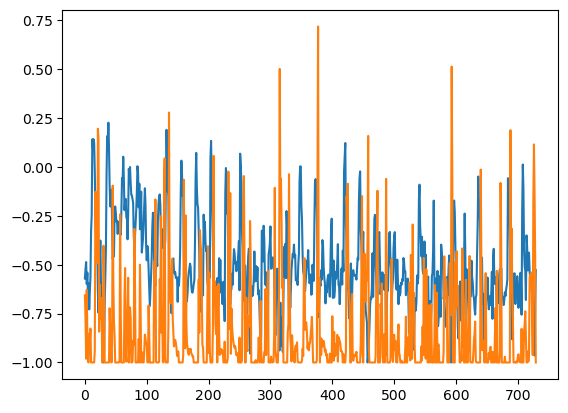

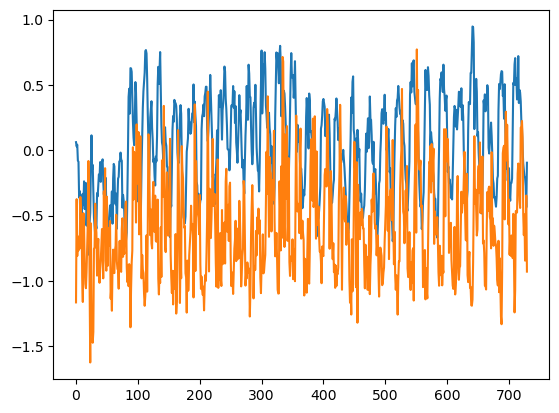

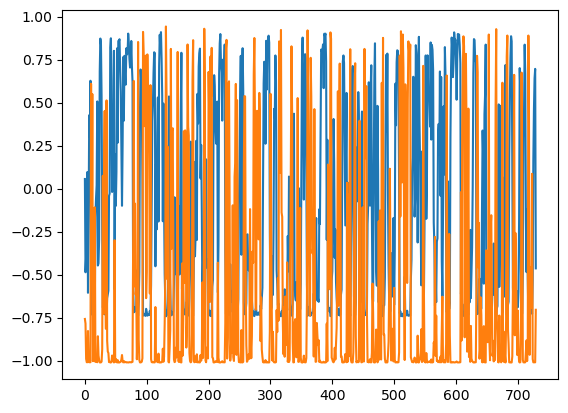

In [30]:
plt.plot(scaled_data_train[10])
plt.show()
plt.plot(vae_data_train[10])
plt.show()
plt.plot(gan_data_train[10])
plt.show()

Clip energy consumption at 0 and rescale

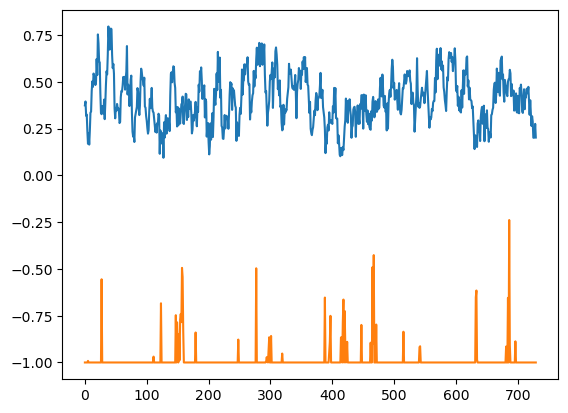

In [36]:
clipped_vae_train = np.clip(vae_data_train_rescaled, a_min=0, a_max=None)
clipped_temp, clipped_energy = clipped_vae_train[:,:,0], clipped_vae_train[:,:,1]
clipped_temp, clipped_energy = scalers['G.air.T'].fit_transform(clipped_temp), scalers['G.E_th_I'].fit_transform(clipped_energy) 

clipped_vae_train = np.stack((clipped_temp, clipped_energy), axis=-1)
plt.plot(clipped_vae_train[50])

In [15]:
import tensorflow as tf

# Hide GPU from visible devices
#tf.config.set_visible_devices([], 'GPU')
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [31]:
def test_cnn_wrapper(data):
    mse, mae, r2 = 0, 0, 0

    # Run each CNN training 10 times to ensure results are significant and not outliers
    for i in range(10):
        print(f'RUN: {i}')
        results = test_cnn(data)
        mse += results['mse']
        mae += results['mae']
        r2  += results['r2']

    return {'mse':mse/10, 'mae':mae/10, 'r2':r2/10}
        

<h3> Use CNN to assess ground truth data </h3>

In [32]:
gt_test = test_cnn_wrapper(scaled_data_train)
print(gt_test['mse'], gt_test['mae'], gt_test['r2'])

RUN: 0
Epoch 1/100
6/6 [==============================] - 1s 55ms/step - loss: 0.6255 - mse: 0.6255 - mae: 0.7147 - accuracy: 0.0000e+00 - val_loss: 0.5019 - val_mse: 0.5019 - val_mae: 0.6241 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 9ms/step - loss: 0.4149 - mse: 0.4149 - mae: 0.5299 - accuracy: 0.0000e+00 - val_loss: 0.3193 - val_mse: 0.3193 - val_mae: 0.4729 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 10ms/step - loss: 0.2686 - mse: 0.2686 - mae: 0.3976 - accuracy: 0.0000e+00 - val_loss: 0.2360 - val_mse: 0.2360 - val_mae: 0.4006 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 0s 10ms/step - loss: 0.2052 - mse: 0.2052 - mae: 0.3373 - accuracy: 0.0000e+00 - val_loss: 0.2014 - val_mse: 0.2014 - val_mae: 0.3694 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/100
6/6 [==============================] - 0s 11ms/step - loss: 0.1850 - mse: 0.1850 -

Epoch 38/100
6/6 [==============================] - 0s 13ms/step - loss: 0.1061 - mse: 0.1061 - mae: 0.2270 - accuracy: 0.0000e+00 - val_loss: 0.1324 - val_mse: 0.1324 - val_mae: 0.2735 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 39/100
6/6 [==============================] - 0s 11ms/step - loss: 0.1056 - mse: 0.1056 - mae: 0.2262 - accuracy: 0.0000e+00 - val_loss: 0.1300 - val_mse: 0.1300 - val_mae: 0.2646 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 40/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1054 - mse: 0.1054 - mae: 0.2258 - accuracy: 0.0465 - val_loss: 0.1295 - val_mse: 0.1295 - val_mae: 0.2623 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 41/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1046 - mse: 0.1046 - mae: 0.2251 - accuracy: 0.0233 - val_loss: 0.1298 - val_mse: 0.1298 - val_mae: 0.2603 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 42/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1040 - mse: 0.1040 - mae: 0.2245 - a

6/6 [==============================] - 0s 12ms/step - loss: 0.0893 - mse: 0.0893 - mae: 0.2124 - accuracy: 0.0349 - val_loss: 0.1296 - val_mse: 0.1296 - val_mae: 0.2621 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 76/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0891 - mse: 0.0891 - mae: 0.2116 - accuracy: 0.0349 - val_loss: 0.1282 - val_mse: 0.1282 - val_mae: 0.2527 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 77/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0893 - mse: 0.0893 - mae: 0.2127 - accuracy: 0.0581 - val_loss: 0.1291 - val_mse: 0.1291 - val_mae: 0.2610 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 78/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0883 - mse: 0.0883 - mae: 0.2129 - accuracy: 0.0465 - val_loss: 0.1297 - val_mse: 0.1297 - val_mae: 0.2620 - val_accuracy: 0.0909 - lr: 0.0010
Epoch 79/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0883 - mse: 0.0883 - mae: 0.2120 - accuracy: 0.0116 - val_loss:

6/6 [==============================] - 0s 9ms/step - loss: 0.1609 - mse: 0.1609 - mae: 0.2893 - accuracy: 0.0000e+00 - val_loss: 0.1730 - val_mse: 0.1730 - val_mae: 0.3315 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 12/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1573 - mse: 0.1573 - mae: 0.2855 - accuracy: 0.0233 - val_loss: 0.1672 - val_mse: 0.1672 - val_mae: 0.3199 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 13/100
6/6 [==============================] - 0s 11ms/step - loss: 0.1550 - mse: 0.1550 - mae: 0.2829 - accuracy: 0.0000e+00 - val_loss: 0.1651 - val_mse: 0.1651 - val_mae: 0.3162 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 14/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1514 - mse: 0.1514 - mae: 0.2784 - accuracy: 0.0000e+00 - val_loss: 0.1644 - val_mse: 0.1644 - val_mae: 0.3178 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 15/100
6/6 [==============================] - 0s 12ms/step - loss: 0.1480 - mse: 0.1480 - mae: 0.2744 - accur

Epoch 48/100
6/6 [==============================] - 0s 12ms/step - loss: 0.1068 - mse: 0.1068 - mae: 0.2276 - accuracy: 0.0465 - val_loss: 0.1337 - val_mse: 0.1337 - val_mae: 0.2708 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 49/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1052 - mse: 0.1052 - mae: 0.2277 - accuracy: 0.0581 - val_loss: 0.1306 - val_mse: 0.1306 - val_mae: 0.2632 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 50/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1052 - mse: 0.1052 - mae: 0.2254 - accuracy: 0.0465 - val_loss: 0.1306 - val_mse: 0.1306 - val_mae: 0.2588 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 51/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1053 - mse: 0.1053 - mae: 0.2274 - accuracy: 0.0465 - val_loss: 0.1301 - val_mse: 0.1301 - val_mae: 0.2607 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 52/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1043 - mse: 0.1043 - mae: 0.2272 - accu

Epoch 85/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0900 - mse: 0.0900 - mae: 0.2123 - accuracy: 0.0465 - val_loss: 0.1368 - val_mse: 0.1368 - val_mae: 0.2804 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 86/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0904 - mse: 0.0904 - mae: 0.2158 - accuracy: 0.0465 - val_loss: 0.1297 - val_mse: 0.1297 - val_mae: 0.2581 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 87/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0897 - mse: 0.0897 - mae: 0.2120 - accuracy: 0.0349 - val_loss: 0.1309 - val_mse: 0.1309 - val_mae: 0.2571 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 88/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0896 - mse: 0.0896 - mae: 0.2140 - accuracy: 0.0465 - val_loss: 0.1297 - val_mse: 0.1297 - val_mae: 0.2586 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 89/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0886 - mse: 0.0886 - mae: 0.2111 - accura

Epoch 21/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1414 - mse: 0.1414 - mae: 0.2639 - accuracy: 0.0000e+00 - val_loss: 0.1586 - val_mse: 0.1586 - val_mae: 0.3049 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 22/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1413 - mse: 0.1413 - mae: 0.2644 - accuracy: 0.0000e+00 - val_loss: 0.1703 - val_mse: 0.1703 - val_mae: 0.3374 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 23/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1378 - mse: 0.1378 - mae: 0.2630 - accuracy: 0.0000e+00 - val_loss: 0.1700 - val_mse: 0.1700 - val_mae: 0.3374 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 24/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1350 - mse: 0.1350 - mae: 0.2579 - accuracy: 0.0000e+00 - val_loss: 0.1613 - val_mse: 0.1613 - val_mae: 0.3200 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 25/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1334 - mse: 0.1334 - m

Epoch 58/100
6/6 [==============================] - 0s 11ms/step - loss: 0.1078 - mse: 0.1078 - mae: 0.2278 - accuracy: 0.0698 - val_loss: 0.1369 - val_mse: 0.1369 - val_mae: 0.2719 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 59/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1076 - mse: 0.1076 - mae: 0.2279 - accuracy: 0.0581 - val_loss: 0.1418 - val_mse: 0.1418 - val_mae: 0.2887 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 60/100
6/6 [==============================] - 0s 11ms/step - loss: 0.1058 - mse: 0.1058 - mae: 0.2259 - accuracy: 0.0465 - val_loss: 0.1400 - val_mse: 0.1400 - val_mae: 0.2839 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 61/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1056 - mse: 0.1056 - mae: 0.2254 - accuracy: 0.0349 - val_loss: 0.1458 - val_mse: 0.1458 - val_mae: 0.2984 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 62/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1060 - mse: 0.1060 - mae: 0.2272 - accurac

6/6 [==============================] - 0s 11ms/step - loss: 0.0954 - mse: 0.0954 - mae: 0.2162 - accuracy: 0.0465 - val_loss: 0.1453 - val_mse: 0.1453 - val_mae: 0.2948 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 96/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0958 - mse: 0.0958 - mae: 0.2187 - accuracy: 0.0581 - val_loss: 0.1406 - val_mse: 0.1406 - val_mae: 0.2860 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 97/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0950 - mse: 0.0950 - mae: 0.2152 - accuracy: 0.0581 - val_loss: 0.1402 - val_mse: 0.1402 - val_mae: 0.2825 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 98/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0943 - mse: 0.0943 - mae: 0.2151 - accuracy: 0.0465 - val_loss: 0.1369 - val_mse: 0.1369 - val_mae: 0.2761 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 99/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0943 - mse: 0.0943 - mae: 0.2158 - accuracy: 0.0581 

Epoch 31/100
6/6 [==============================] - 0s 12ms/step - loss: 0.1185 - mse: 0.1185 - mae: 0.2396 - accuracy: 0.0000e+00 - val_loss: 0.1521 - val_mse: 0.1521 - val_mae: 0.3032 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 32/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1165 - mse: 0.1165 - mae: 0.2381 - accuracy: 0.0116 - val_loss: 0.1498 - val_mse: 0.1498 - val_mae: 0.2974 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 33/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1160 - mse: 0.1160 - mae: 0.2371 - accuracy: 0.0233 - val_loss: 0.1470 - val_mse: 0.1470 - val_mae: 0.2909 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 34/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1154 - mse: 0.1154 - mae: 0.2367 - accuracy: 0.0233 - val_loss: 0.1478 - val_mse: 0.1478 - val_mae: 0.2939 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 35/100
6/6 [==============================] - 0s 12ms/step - loss: 0.1146 - mse: 0.1146 - mae: 0.2371 - 

Epoch 68/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0964 - mse: 0.0964 - mae: 0.2171 - accuracy: 0.0581 - val_loss: 0.1393 - val_mse: 0.1393 - val_mae: 0.2764 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 69/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0965 - mse: 0.0965 - mae: 0.2183 - accuracy: 0.0698 - val_loss: 0.1402 - val_mse: 0.1402 - val_mae: 0.2806 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 70/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0960 - mse: 0.0960 - mae: 0.2174 - accuracy: 0.0465 - val_loss: 0.1403 - val_mse: 0.1403 - val_mae: 0.2803 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 71/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0959 - mse: 0.0959 - mae: 0.2163 - accuracy: 0.0465 - val_loss: 0.1484 - val_mse: 0.1484 - val_mae: 0.3022 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 72/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0966 - mse: 0.0966 - mae: 0.2200 - accu

6/6 [==============================] - 0s 10ms/step - loss: 0.2128 - mse: 0.2128 - mae: 0.3430 - accuracy: 0.0000e+00 - val_loss: 0.2394 - val_mse: 0.2394 - val_mae: 0.4290 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1959 - mse: 0.1959 - mae: 0.3410 - accuracy: 0.0000e+00 - val_loss: 0.1821 - val_mse: 0.1821 - val_mae: 0.3383 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1790 - mse: 0.1790 - mae: 0.3140 - accuracy: 0.0000e+00 - val_loss: 0.1835 - val_mse: 0.1835 - val_mae: 0.3391 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 7/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1741 - mse: 0.1741 - mae: 0.3081 - accuracy: 0.0000e+00 - val_loss: 0.1662 - val_mse: 0.1662 - val_mae: 0.2894 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 8/100
6/6 [==============================] - 0s 11ms/step - loss: 0.1723 - mse: 0.1723 - mae: 0.3073 - accura

Epoch 41/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1087 - mse: 0.1087 - mae: 0.2297 - accuracy: 0.0581 - val_loss: 0.1335 - val_mse: 0.1335 - val_mae: 0.2759 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 42/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1073 - mse: 0.1073 - mae: 0.2275 - accuracy: 0.0349 - val_loss: 0.1332 - val_mse: 0.1332 - val_mae: 0.2725 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 43/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1068 - mse: 0.1068 - mae: 0.2275 - accuracy: 0.0349 - val_loss: 0.1301 - val_mse: 0.1301 - val_mae: 0.2651 - val_accuracy: 0.0909 - lr: 0.0010
Epoch 44/100
6/6 [==============================] - 0s 11ms/step - loss: 0.1062 - mse: 0.1062 - mae: 0.2259 - accuracy: 0.0233 - val_loss: 0.1287 - val_mse: 0.1287 - val_mae: 0.2596 - val_accuracy: 0.0909 - lr: 0.0010
Epoch 45/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1063 - mse: 0.1063 - mae: 0.2266 - accuracy: 0.0465 

Epoch 79/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0940 - mse: 0.0940 - mae: 0.2168 - accuracy: 0.0465 - val_loss: 0.1311 - val_mse: 0.1311 - val_mae: 0.2620 - val_accuracy: 0.0909 - lr: 0.0010
Epoch 80/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0939 - mse: 0.0939 - mae: 0.2179 - accuracy: 0.0581 - val_loss: 0.1294 - val_mse: 0.1294 - val_mae: 0.2630 - val_accuracy: 0.0909 - lr: 0.0010
Epoch 81/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0928 - mse: 0.0928 - mae: 0.2155 - accuracy: 0.0581 - val_loss: 0.1328 - val_mse: 0.1328 - val_mae: 0.2683 - val_accuracy: 0.0909 - lr: 0.0010
Epoch 82/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0920 - mse: 0.0920 - mae: 0.2152 - accuracy: 0.0465 - val_loss: 0.1287 - val_mse: 0.1287 - val_mae: 0.2596 - val_accuracy: 0.0909 - lr: 0.0010
Epoch 83/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0917 - mse: 0.0917 - mae: 0.2136 - accuracy: 0.0465 - 

6/6 [==============================] - 0s 10ms/step - loss: 0.1531 - mse: 0.1531 - mae: 0.2850 - accuracy: 0.0000e+00 - val_loss: 0.1744 - val_mse: 0.1744 - val_mae: 0.3307 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 16/100
6/6 [==============================] - 0s 12ms/step - loss: 0.1489 - mse: 0.1489 - mae: 0.2794 - accuracy: 0.0000e+00 - val_loss: 0.1647 - val_mse: 0.1647 - val_mae: 0.3017 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 17/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1482 - mse: 0.1482 - mae: 0.2755 - accuracy: 0.0116 - val_loss: 0.1606 - val_mse: 0.1606 - val_mae: 0.2977 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 18/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1430 - mse: 0.1430 - mae: 0.2670 - accuracy: 0.0233 - val_loss: 0.1636 - val_mse: 0.1636 - val_mae: 0.3118 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 19/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1398 - mse: 0.1398 - mae: 0.2621 - accuracy:

Epoch 52/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1056 - mse: 0.1056 - mae: 0.2266 - accuracy: 0.0581 - val_loss: 0.1387 - val_mse: 0.1387 - val_mae: 0.2750 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 53/100
6/6 [==============================] - 0s 11ms/step - loss: 0.1044 - mse: 0.1044 - mae: 0.2240 - accuracy: 0.0581 - val_loss: 0.1376 - val_mse: 0.1376 - val_mae: 0.2754 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 54/100
6/6 [==============================] - 0s 11ms/step - loss: 0.1041 - mse: 0.1041 - mae: 0.2248 - accuracy: 0.0581 - val_loss: 0.1416 - val_mse: 0.1416 - val_mae: 0.2859 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 55/100
6/6 [==============================] - 0s 13ms/step - loss: 0.1041 - mse: 0.1041 - mae: 0.2242 - accuracy: 0.0581 - val_loss: 0.1460 - val_mse: 0.1460 - val_mae: 0.2959 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 56/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1037 - mse: 0.1037 - mae: 0.2259 - accu

Epoch 88/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0931 - mse: 0.0931 - mae: 0.2154 - accuracy: 0.0349 - val_loss: 0.1385 - val_mse: 0.1385 - val_mae: 0.2775 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04
Epoch 89/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0931 - mse: 0.0931 - mae: 0.2172 - accuracy: 0.0465 - val_loss: 0.1372 - val_mse: 0.1372 - val_mae: 0.2740 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04
Epoch 90/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0926 - mse: 0.0926 - mae: 0.2148 - accuracy: 0.0349 - val_loss: 0.1376 - val_mse: 0.1376 - val_mae: 0.2745 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04
Epoch 91/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0926 - mse: 0.0926 - mae: 0.2144 - accuracy: 0.0349 - val_loss: 0.1387 - val_mse: 0.1387 - val_mae: 0.2781 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04
Epoch 92/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0921 - mse: 0.0921 - mae:

Epoch 24/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1216 - mse: 0.1216 - mae: 0.2420 - accuracy: 0.0581 - val_loss: 0.1643 - val_mse: 0.1643 - val_mae: 0.3256 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 25/100
6/6 [==============================] - 0s 11ms/step - loss: 0.1188 - mse: 0.1188 - mae: 0.2408 - accuracy: 0.0349 - val_loss: 0.1634 - val_mse: 0.1634 - val_mae: 0.3234 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 26/100
6/6 [==============================] - 0s 11ms/step - loss: 0.1181 - mse: 0.1181 - mae: 0.2397 - accuracy: 0.0349 - val_loss: 0.1642 - val_mse: 0.1642 - val_mae: 0.3288 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 27/100
6/6 [==============================] - 0s 11ms/step - loss: 0.1176 - mse: 0.1176 - mae: 0.2408 - accuracy: 0.0233 - val_loss: 0.1555 - val_mse: 0.1555 - val_mae: 0.3096 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 28/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1150 - mse: 0.1150 - mae: 0.2351 - accu

6/6 [==============================] - 0s 10ms/step - loss: 0.0956 - mse: 0.0956 - mae: 0.2164 - accuracy: 0.0814 - val_loss: 0.1479 - val_mse: 0.1479 - val_mae: 0.2925 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 62/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0950 - mse: 0.0950 - mae: 0.2173 - accuracy: 0.0465 - val_loss: 0.1473 - val_mse: 0.1473 - val_mae: 0.2943 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 63/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0940 - mse: 0.0940 - mae: 0.2153 - accuracy: 0.0581 - val_loss: 0.1427 - val_mse: 0.1427 - val_mae: 0.2786 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 64/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0939 - mse: 0.0939 - mae: 0.2147 - accuracy: 0.0698 - val_loss: 0.1504 - val_mse: 0.1504 - val_mae: 0.3024 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 65/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0939 - mse: 0.0939 - mae: 0.2160 - accuracy: 0.0698 - 

6/6 [==============================] - 0s 11ms/step - loss: 0.0798 - mse: 0.0798 - mae: 0.2026 - accuracy: 0.1047 - val_loss: 0.1412 - val_mse: 0.1412 - val_mae: 0.2723 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 99/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0797 - mse: 0.0797 - mae: 0.2029 - accuracy: 0.1047 - val_loss: 0.1421 - val_mse: 0.1421 - val_mae: 0.2785 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 100/100
1/1 [==============================] - 0s 63ms/step
RUN: 7
Epoch 1/100
6/6 [==============================] - 2s 46ms/step - loss: 0.6352 - mse: 0.6352 - mae: 0.7246 - accuracy: 0.0000e+00 - val_loss: 0.5049 - val_mse: 0.5049 - val_mae: 0.6260 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 10ms/step - loss: 0.4268 - mse: 0.4268 - mae: 0.5447 - accuracy: 0.0116 - val_loss: 0.3264 - val_mse: 0.3264 - val_mae: 0.4605 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] -

6/6 [==============================] - 0s 10ms/step - loss: 0.1120 - mse: 0.1120 - mae: 0.2326 - accuracy: 0.0349 - val_loss: 0.1455 - val_mse: 0.1455 - val_mae: 0.2755 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 35/100
6/6 [==============================] - 0s 11ms/step - loss: 0.1110 - mse: 0.1110 - mae: 0.2304 - accuracy: 0.0465 - val_loss: 0.1468 - val_mse: 0.1468 - val_mae: 0.2799 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 36/100
6/6 [==============================] - 0s 12ms/step - loss: 0.1097 - mse: 0.1097 - mae: 0.2301 - accuracy: 0.0465 - val_loss: 0.1463 - val_mse: 0.1463 - val_mae: 0.2828 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 37/100
6/6 [==============================] - 0s 11ms/step - loss: 0.1086 - mse: 0.1086 - mae: 0.2283 - accuracy: 0.0465 - val_loss: 0.1450 - val_mse: 0.1450 - val_mae: 0.2775 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 38/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1079 - mse: 0.1079 - mae: 0.2273 - accuracy: 0.0349

6/6 [==============================] - 0s 9ms/step - loss: 0.0934 - mse: 0.0934 - mae: 0.2163 - accuracy: 0.0233 - val_loss: 0.1410 - val_mse: 0.1410 - val_mae: 0.2642 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 72/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0944 - mse: 0.0944 - mae: 0.2171 - accuracy: 0.0465 - val_loss: 0.1411 - val_mse: 0.1411 - val_mae: 0.2571 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 73/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0936 - mse: 0.0936 - mae: 0.2160 - accuracy: 0.0349 - val_loss: 0.1399 - val_mse: 0.1399 - val_mae: 0.2654 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 74/100
1/6 [====>.........................] - ETA: 0s - loss: 0.0922 - mse: 0.0922 - mae: 0.2060 - accuracy: 0.0000e+00
Epoch 74: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 [==============================] - 0s 11ms/step - loss: 0.0940 - mse: 0.0940 - mae: 0.2171 - accuracy: 0.0465 - val_loss: 0.1466 - val_mse: 0.1466 - val_

6/6 [==============================] - 0s 11ms/step - loss: 0.1766 - mse: 0.1766 - mae: 0.3134 - accuracy: 0.0000e+00 - val_loss: 0.2010 - val_mse: 0.2010 - val_mae: 0.3423 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 7/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1699 - mse: 0.1699 - mae: 0.3020 - accuracy: 0.0000e+00 - val_loss: 0.1963 - val_mse: 0.1963 - val_mae: 0.3436 - val_accuracy: 0.0909 - lr: 0.0010
Epoch 8/100
6/6 [==============================] - 0s 11ms/step - loss: 0.1640 - mse: 0.1640 - mae: 0.2938 - accuracy: 0.0000e+00 - val_loss: 0.1927 - val_mse: 0.1927 - val_mae: 0.3382 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 9/100
6/6 [==============================] - 0s 11ms/step - loss: 0.1617 - mse: 0.1617 - mae: 0.2912 - accuracy: 0.0000e+00 - val_loss: 0.1923 - val_mse: 0.1923 - val_mae: 0.3345 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 10/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1598 - mse: 0.1598 - mae: 0.2877 - accura

Epoch 43/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1088 - mse: 0.1088 - mae: 0.2291 - accuracy: 0.0116 - val_loss: 0.1512 - val_mse: 0.1512 - val_mae: 0.2946 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 44/100
6/6 [==============================] - 0s 11ms/step - loss: 0.1089 - mse: 0.1089 - mae: 0.2322 - accuracy: 0.0116 - val_loss: 0.1446 - val_mse: 0.1446 - val_mae: 0.2784 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 45/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1072 - mse: 0.1072 - mae: 0.2267 - accuracy: 0.0000e+00 - val_loss: 0.1467 - val_mse: 0.1467 - val_mae: 0.2820 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 46/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1064 - mse: 0.1064 - mae: 0.2273 - accuracy: 0.0116 - val_loss: 0.1441 - val_mse: 0.1441 - val_mae: 0.2814 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 47/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1058 - mse: 0.1058 - mae: 0.2267 - accurac

6/6 [==============================] - 0s 10ms/step - loss: 0.0928 - mse: 0.0928 - mae: 0.2156 - accuracy: 0.0349 - val_loss: 0.1384 - val_mse: 0.1384 - val_mae: 0.2612 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 81/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0922 - mse: 0.0922 - mae: 0.2140 - accuracy: 0.0233 - val_loss: 0.1402 - val_mse: 0.1402 - val_mae: 0.2645 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 82/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0920 - mse: 0.0920 - mae: 0.2144 - accuracy: 0.0233 - val_loss: 0.1445 - val_mse: 0.1445 - val_mae: 0.2820 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 83/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0920 - mse: 0.0920 - mae: 0.2159 - accuracy: 0.0233 - val_loss: 0.1436 - val_mse: 0.1436 - val_mae: 0.2820 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 84/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0903 - mse: 0.0903 - mae: 0.2113 - accuracy: 0.0116 -

6/6 [==============================] - 0s 11ms/step - loss: 0.1442 - mse: 0.1442 - mae: 0.2690 - accuracy: 0.0000e+00 - val_loss: 0.1609 - val_mse: 0.1609 - val_mae: 0.3089 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 17/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1406 - mse: 0.1406 - mae: 0.2610 - accuracy: 0.0116 - val_loss: 0.1723 - val_mse: 0.1723 - val_mae: 0.3410 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 18/100
6/6 [==============================] - 0s 11ms/step - loss: 0.1382 - mse: 0.1382 - mae: 0.2606 - accuracy: 0.0116 - val_loss: 0.1666 - val_mse: 0.1666 - val_mae: 0.3316 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 19/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1350 - mse: 0.1350 - mae: 0.2620 - accuracy: 0.0000e+00 - val_loss: 0.1553 - val_mse: 0.1553 - val_mae: 0.3036 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 20/100
6/6 [==============================] - 0s 11ms/step - loss: 0.1333 - mse: 0.1333 - mae: 0.2594 - accurac

Epoch 53/100
6/6 [==============================] - 0s 12ms/step - loss: 0.1030 - mse: 0.1030 - mae: 0.2246 - accuracy: 0.0116 - val_loss: 0.1339 - val_mse: 0.1339 - val_mae: 0.2702 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 54/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1023 - mse: 0.1023 - mae: 0.2230 - accuracy: 0.0233 - val_loss: 0.1341 - val_mse: 0.1341 - val_mae: 0.2714 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 55/100
6/6 [==============================] - 0s 11ms/step - loss: 0.1025 - mse: 0.1025 - mae: 0.2242 - accuracy: 0.0349 - val_loss: 0.1337 - val_mse: 0.1337 - val_mae: 0.2714 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 56/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1015 - mse: 0.1015 - mae: 0.2219 - accuracy: 0.0116 - val_loss: 0.1346 - val_mse: 0.1346 - val_mae: 0.2722 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 57/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1014 - mse: 0.1014 - mae: 0.2235 - accu

Epoch 89/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0889 - mse: 0.0889 - mae: 0.2109 - accuracy: 0.0349 - val_loss: 0.1347 - val_mse: 0.1347 - val_mae: 0.2731 - val_accuracy: 0.0455 - lr: 5.0000e-04
Epoch 90/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0888 - mse: 0.0888 - mae: 0.2104 - accuracy: 0.0233 - val_loss: 0.1349 - val_mse: 0.1349 - val_mae: 0.2736 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04
Epoch 91/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0884 - mse: 0.0884 - mae: 0.2115 - accuracy: 0.0349 - val_loss: 0.1320 - val_mse: 0.1320 - val_mae: 0.2626 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04
Epoch 92/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0883 - mse: 0.0883 - mae: 0.2097 - accuracy: 0.0465 - val_loss: 0.1361 - val_mse: 0.1361 - val_mae: 0.2778 - val_accuracy: 0.0455 - lr: 5.0000e-04
Epoch 93/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0879 - mse: 0.0879 - mae: 0.2088

<h3> Use CNN to assess synthetic data</h3>

VAEs

In [33]:
synth_test = test_cnn_wrapper(vae_data_train[0:216,:,:])
print(synth_test['mse'], synth_test['mae'], synth_test['r2'])

RUN: 0
Epoch 1/100
11/11 [==============================] - 1s 25ms/step - loss: 0.6969 - mse: 0.6969 - mae: 0.7075 - accuracy: 0.0058 - val_loss: 0.4899 - val_mse: 0.4899 - val_mae: 0.6067 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5730 - mse: 0.5730 - mae: 0.6124 - accuracy: 0.0058 - val_loss: 0.4039 - val_mse: 0.4039 - val_mae: 0.5303 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4389 - mse: 0.4389 - mae: 0.5161 - accuracy: 0.0000e+00 - val_loss: 0.3337 - val_mse: 0.3337 - val_mae: 0.4753 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 4/100
11/11 [==============================] - 0s 10ms/step - loss: 0.3445 - mse: 0.3445 - mae: 0.4508 - accuracy: 0.0407 - val_loss: 0.3033 - val_mse: 0.3033 - val_mae: 0.4509 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 5/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2971 - mse: 0.2971 - mae: 0.417

11/11 [==============================] - 0s 7ms/step - loss: 0.0824 - mse: 0.0824 - mae: 0.2208 - accuracy: 0.1453 - val_loss: 0.1315 - val_mse: 0.1315 - val_mae: 0.2778 - val_accuracy: 0.1136 - lr: 0.0010
Epoch 39/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0794 - mse: 0.0794 - mae: 0.2178 - accuracy: 0.1802 - val_loss: 0.1309 - val_mse: 0.1309 - val_mae: 0.2760 - val_accuracy: 0.1364 - lr: 0.0010
Epoch 40/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0702 - mse: 0.0702 - mae: 0.2040 - accuracy: 0.1744 - val_loss: 0.1122 - val_mse: 0.1122 - val_mae: 0.2597 - val_accuracy: 0.1591 - lr: 0.0010
Epoch 41/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0757 - mse: 0.0757 - mae: 0.2115 - accuracy: 0.1977 - val_loss: 0.1084 - val_mse: 0.1084 - val_mae: 0.2582 - val_accuracy: 0.0909 - lr: 0.0010
Epoch 42/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0779 - mse: 0.0779 - mae: 0.2138 - accuracy: 0.2035 - val_lo

11/11 [==============================] - 0s 10ms/step - loss: 0.0443 - mse: 0.0443 - mae: 0.1617 - accuracy: 0.2500 - val_loss: 0.0934 - val_mse: 0.0934 - val_mae: 0.2269 - val_accuracy: 0.1591 - lr: 5.0000e-04
Epoch 75/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0440 - mse: 0.0440 - mae: 0.1614 - accuracy: 0.2674 - val_loss: 0.0973 - val_mse: 0.0973 - val_mae: 0.2310 - val_accuracy: 0.2500 - lr: 5.0000e-04
Epoch 76/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0439 - mse: 0.0439 - mae: 0.1612 - accuracy: 0.2326 - val_loss: 0.0912 - val_mse: 0.0912 - val_mae: 0.2263 - val_accuracy: 0.1364 - lr: 5.0000e-04
Epoch 77/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0443 - mse: 0.0443 - mae: 0.1616 - accuracy: 0.2558 - val_loss: 0.0898 - val_mse: 0.0898 - val_mae: 0.2264 - val_accuracy: 0.2045 - lr: 5.0000e-04
Epoch 78/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0437 - mse: 0.0437 - mae: 0.1605 - accuracy

11/11 [==============================] - 0s 11ms/step - loss: 0.2194 - mse: 0.2194 - mae: 0.3554 - accuracy: 0.0814 - val_loss: 0.2420 - val_mse: 0.2420 - val_mae: 0.3714 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 10/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1957 - mse: 0.1957 - mae: 0.3359 - accuracy: 0.0640 - val_loss: 0.2426 - val_mse: 0.2426 - val_mae: 0.3751 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 11/100
11/11 [==============================] - 0s 9ms/step - loss: 0.1790 - mse: 0.1790 - mae: 0.3209 - accuracy: 0.0581 - val_loss: 0.2364 - val_mse: 0.2364 - val_mae: 0.3651 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 12/100
11/11 [==============================] - 0s 9ms/step - loss: 0.1816 - mse: 0.1816 - mae: 0.3251 - accuracy: 0.0581 - val_loss: 0.2269 - val_mse: 0.2269 - val_mae: 0.3592 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 13/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1676 - mse: 0.1676 - mae: 0.3113 - accuracy:

11/11 [==============================] - 0s 12ms/step - loss: 0.0795 - mse: 0.0795 - mae: 0.2155 - accuracy: 0.1744 - val_loss: 0.1464 - val_mse: 0.1464 - val_mae: 0.2778 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 47/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0830 - mse: 0.0830 - mae: 0.2228 - accuracy: 0.1686 - val_loss: 0.1360 - val_mse: 0.1360 - val_mae: 0.2680 - val_accuracy: 0.0909 - lr: 0.0010
Epoch 48/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0798 - mse: 0.0798 - mae: 0.2168 - accuracy: 0.1686 - val_loss: 0.1344 - val_mse: 0.1344 - val_mae: 0.2723 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 49/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0907 - mse: 0.0907 - mae: 0.2316 - accuracy: 0.1860 - val_loss: 0.1576 - val_mse: 0.1576 - val_mae: 0.2890 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 50/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0877 - mse: 0.0877 - mae: 0.2300 - accuracy: 0.1512 - val

Epoch 82/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0597 - mse: 0.0597 - mae: 0.1851 - accuracy: 0.2267 - val_loss: 0.1228 - val_mse: 0.1228 - val_mae: 0.2506 - val_accuracy: 0.1136 - lr: 5.0000e-04
Epoch 83/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0600 - mse: 0.0600 - mae: 0.1857 - accuracy: 0.2151 - val_loss: 0.1225 - val_mse: 0.1225 - val_mae: 0.2499 - val_accuracy: 0.1136 - lr: 5.0000e-04
Epoch 84/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0592 - mse: 0.0592 - mae: 0.1832 - accuracy: 0.1860 - val_loss: 0.1261 - val_mse: 0.1261 - val_mae: 0.2548 - val_accuracy: 0.1591 - lr: 5.0000e-04
Epoch 85/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0591 - mse: 0.0591 - mae: 0.1835 - accuracy: 0.2151 - val_loss: 0.1224 - val_mse: 0.1224 - val_mae: 0.2532 - val_accuracy: 0.1591 - lr: 5.0000e-04
Epoch 86/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0577 - mse: 0.0577 - mae: 0.1

11/11 [==============================] - 0s 8ms/step - loss: 0.1573 - mse: 0.1573 - mae: 0.2978 - accuracy: 0.1163 - val_loss: 0.1705 - val_mse: 0.1705 - val_mae: 0.3109 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 18/100
11/11 [==============================] - 0s 9ms/step - loss: 0.1505 - mse: 0.1505 - mae: 0.2896 - accuracy: 0.1163 - val_loss: 0.1637 - val_mse: 0.1637 - val_mae: 0.3064 - val_accuracy: 0.0682 - lr: 0.0010
Epoch 19/100
11/11 [==============================] - 0s 9ms/step - loss: 0.1363 - mse: 0.1363 - mae: 0.2765 - accuracy: 0.1337 - val_loss: 0.1673 - val_mse: 0.1673 - val_mae: 0.3127 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 20/100
11/11 [==============================] - 0s 9ms/step - loss: 0.1435 - mse: 0.1435 - mae: 0.2890 - accuracy: 0.1163 - val_loss: 0.1988 - val_mse: 0.1988 - val_mae: 0.3511 - val_accuracy: 0.0909 - lr: 0.0010
Epoch 21/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1456 - mse: 0.1456 - mae: 0.2851 - accuracy: 0.1221 - val_los

11/11 [==============================] - 0s 9ms/step - loss: 0.0815 - mse: 0.0815 - mae: 0.2175 - accuracy: 0.1860 - val_loss: 0.1046 - val_mse: 0.1046 - val_mae: 0.2414 - val_accuracy: 0.1591 - lr: 0.0010
Epoch 55/100
 1/11 [=>............................] - ETA: 0s - loss: 0.1095 - mse: 0.1095 - mae: 0.2377 - accuracy: 0.3125
Epoch 55: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
11/11 [==============================] - 0s 7ms/step - loss: 0.0774 - mse: 0.0774 - mae: 0.2122 - accuracy: 0.2209 - val_loss: 0.1126 - val_mse: 0.1126 - val_mae: 0.2501 - val_accuracy: 0.1364 - lr: 0.0010
Epoch 56/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0701 - mse: 0.0701 - mae: 0.2016 - accuracy: 0.2209 - val_loss: 0.1048 - val_mse: 0.1048 - val_mae: 0.2394 - val_accuracy: 0.1364 - lr: 5.0000e-04
Epoch 57/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0675 - mse: 0.0675 - mae: 0.1982 - accuracy: 0.1919 - val_loss: 0.1024 - val_mse: 0.1024

11/11 [==============================] - 0s 11ms/step - loss: 0.0519 - mse: 0.0519 - mae: 0.1737 - accuracy: 0.2442 - val_loss: 0.0953 - val_mse: 0.0953 - val_mae: 0.2255 - val_accuracy: 0.2273 - lr: 2.5000e-04
Epoch 90/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0512 - mse: 0.0512 - mae: 0.1737 - accuracy: 0.2849 - val_loss: 0.0926 - val_mse: 0.0926 - val_mae: 0.2230 - val_accuracy: 0.2273 - lr: 2.5000e-04
Epoch 91/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0504 - mse: 0.0504 - mae: 0.1727 - accuracy: 0.2558 - val_loss: 0.0936 - val_mse: 0.0936 - val_mae: 0.2244 - val_accuracy: 0.2500 - lr: 2.5000e-04
Epoch 92/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0524 - mse: 0.0524 - mae: 0.1740 - accuracy: 0.2326 - val_loss: 0.0947 - val_mse: 0.0947 - val_mae: 0.2252 - val_accuracy: 0.2273 - lr: 2.5000e-04
Epoch 93/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0525 - mse: 0.0525 - mae: 0.1756 - accura

11/11 [==============================] - 0s 11ms/step - loss: 0.1001 - mse: 0.1001 - mae: 0.2405 - accuracy: 0.1105 - val_loss: 0.1529 - val_mse: 0.1529 - val_mae: 0.3022 - val_accuracy: 0.1136 - lr: 0.0010
Epoch 25/100
11/11 [==============================] - 0s 12ms/step - loss: 0.1062 - mse: 0.1062 - mae: 0.2493 - accuracy: 0.1221 - val_loss: 0.1457 - val_mse: 0.1457 - val_mae: 0.2925 - val_accuracy: 0.1591 - lr: 0.0010
Epoch 26/100
11/11 [==============================] - 0s 9ms/step - loss: 0.1011 - mse: 0.1011 - mae: 0.2425 - accuracy: 0.1337 - val_loss: 0.1299 - val_mse: 0.1299 - val_mae: 0.2728 - val_accuracy: 0.1136 - lr: 0.0010
Epoch 27/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0999 - mse: 0.0999 - mae: 0.2396 - accuracy: 0.1279 - val_loss: 0.1555 - val_mse: 0.1555 - val_mae: 0.3002 - val_accuracy: 0.1591 - lr: 0.0010
Epoch 28/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0952 - mse: 0.0952 - mae: 0.2384 - accuracy: 0.1279 - val

11/11 [==============================] - 0s 7ms/step - loss: 0.0521 - mse: 0.0521 - mae: 0.1743 - accuracy: 0.2267 - val_loss: 0.0972 - val_mse: 0.0972 - val_mae: 0.2332 - val_accuracy: 0.2045 - lr: 5.0000e-04
Epoch 61/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0535 - mse: 0.0535 - mae: 0.1766 - accuracy: 0.2209 - val_loss: 0.0986 - val_mse: 0.0986 - val_mae: 0.2345 - val_accuracy: 0.2045 - lr: 5.0000e-04
Epoch 62/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0519 - mse: 0.0519 - mae: 0.1743 - accuracy: 0.2267 - val_loss: 0.0960 - val_mse: 0.0960 - val_mae: 0.2307 - val_accuracy: 0.2045 - lr: 5.0000e-04
Epoch 63/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0520 - mse: 0.0520 - mae: 0.1746 - accuracy: 0.2151 - val_loss: 0.0998 - val_mse: 0.0998 - val_mae: 0.2352 - val_accuracy: 0.2045 - lr: 5.0000e-04
Epoch 64/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0557 - mse: 0.0557 - mae: 0.1797 - accuracy: 

11/11 [==============================] - 0s 10ms/step - loss: 0.0443 - mse: 0.0443 - mae: 0.1612 - accuracy: 0.2384 - val_loss: 0.0902 - val_mse: 0.0902 - val_mae: 0.2231 - val_accuracy: 0.2045 - lr: 1.2500e-04
Epoch 96/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0444 - mse: 0.0444 - mae: 0.1614 - accuracy: 0.2558 - val_loss: 0.0902 - val_mse: 0.0902 - val_mae: 0.2227 - val_accuracy: 0.2045 - lr: 1.2500e-04
Epoch 97/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0447 - mse: 0.0447 - mae: 0.1618 - accuracy: 0.2151 - val_loss: 0.0902 - val_mse: 0.0902 - val_mae: 0.2232 - val_accuracy: 0.2045 - lr: 1.2500e-04
Epoch 98/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0455 - mse: 0.0455 - mae: 0.1629 - accuracy: 0.2733 - val_loss: 0.0903 - val_mse: 0.0903 - val_mae: 0.2243 - val_accuracy: 0.2273 - lr: 1.2500e-04
Epoch 99/100
 1/11 [=>............................] - ETA: 0s - loss: 0.0527 - mse: 0.0527 - mae: 0.1735 - accuracy: 0.4

11/11 [==============================] - 0s 8ms/step - loss: 0.0847 - mse: 0.0847 - mae: 0.2240 - accuracy: 0.1221 - val_loss: 0.2305 - val_mse: 0.2305 - val_mae: 0.3145 - val_accuracy: 0.2045 - lr: 0.0010
Epoch 31/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0922 - mse: 0.0922 - mae: 0.2338 - accuracy: 0.1163 - val_loss: 0.2502 - val_mse: 0.2502 - val_mae: 0.3492 - val_accuracy: 0.1136 - lr: 0.0010
Epoch 32/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0980 - mse: 0.0980 - mae: 0.2385 - accuracy: 0.1221 - val_loss: 0.2419 - val_mse: 0.2419 - val_mae: 0.3163 - val_accuracy: 0.1364 - lr: 0.0010
Epoch 33/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0885 - mse: 0.0885 - mae: 0.2307 - accuracy: 0.1221 - val_loss: 0.2432 - val_mse: 0.2432 - val_mae: 0.3229 - val_accuracy: 0.0909 - lr: 0.0010
Epoch 34/100
10/11 [==========================>...] - ETA: 0s - loss: 0.0865 - mse: 0.0865 - mae: 0.2255 - accuracy: 0.1250
Epoch 34: R

Epoch 66/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0543 - mse: 0.0543 - mae: 0.1780 - accuracy: 0.1395 - val_loss: 0.2041 - val_mse: 0.2041 - val_mae: 0.2890 - val_accuracy: 0.1818 - lr: 5.0000e-04
Epoch 67/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0521 - mse: 0.0521 - mae: 0.1747 - accuracy: 0.1628 - val_loss: 0.2048 - val_mse: 0.2048 - val_mae: 0.2836 - val_accuracy: 0.2045 - lr: 5.0000e-04
Epoch 68/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0532 - mse: 0.0532 - mae: 0.1765 - accuracy: 0.1860 - val_loss: 0.2125 - val_mse: 0.2125 - val_mae: 0.2905 - val_accuracy: 0.1591 - lr: 5.0000e-04
Epoch 69/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0524 - mse: 0.0524 - mae: 0.1756 - accuracy: 0.1977 - val_loss: 0.2116 - val_mse: 0.2116 - val_mae: 0.2809 - val_accuracy: 0.1364 - lr: 5.0000e-04
Epoch 70/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0517 - mse: 0.0517 - mae: 0.1

Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 0.5355 - mse: 0.5355 - mae: 0.5939 - accuracy: 0.0174 - val_loss: 0.4459 - val_mse: 0.4459 - val_mae: 0.5374 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
11/11 [==============================] - 0s 9ms/step - loss: 0.4009 - mse: 0.4009 - mae: 0.4929 - accuracy: 0.0174 - val_loss: 0.3790 - val_mse: 0.3790 - val_mae: 0.4953 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3350 - mse: 0.3350 - mae: 0.4450 - accuracy: 0.0291 - val_loss: 0.3298 - val_mse: 0.3298 - val_mae: 0.4551 - val_accuracy: 0.0682 - lr: 0.0010
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2817 - mse: 0.2817 - mae: 0.4019 - accuracy: 0.0465 - val_loss: 0.3639 - val_mse: 0.3639 - val_mae: 0.4721 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 6/100
11/11 [==============================] - 0s 10ms/step - loss: 0.2843 - mse: 0.2843 - mae: 0.4059 - accuracy: 0.0

11/11 [==============================] - 0s 11ms/step - loss: 0.0756 - mse: 0.0756 - mae: 0.2091 - accuracy: 0.1453 - val_loss: 0.1388 - val_mse: 0.1388 - val_mae: 0.2706 - val_accuracy: 0.1818 - lr: 5.0000e-04
Epoch 39/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0768 - mse: 0.0768 - mae: 0.2128 - accuracy: 0.1628 - val_loss: 0.1204 - val_mse: 0.1204 - val_mae: 0.2605 - val_accuracy: 0.1818 - lr: 5.0000e-04
Epoch 40/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0741 - mse: 0.0741 - mae: 0.2072 - accuracy: 0.1686 - val_loss: 0.1202 - val_mse: 0.1202 - val_mae: 0.2531 - val_accuracy: 0.1591 - lr: 5.0000e-04
Epoch 41/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0729 - mse: 0.0729 - mae: 0.2052 - accuracy: 0.1919 - val_loss: 0.1129 - val_mse: 0.1129 - val_mae: 0.2480 - val_accuracy: 0.1591 - lr: 5.0000e-04
Epoch 42/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0750 - mse: 0.0750 - mae: 0.2093 - accura

Epoch 74/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0571 - mse: 0.0571 - mae: 0.1826 - accuracy: 0.1744 - val_loss: 0.1050 - val_mse: 0.1050 - val_mae: 0.2371 - val_accuracy: 0.2273 - lr: 2.5000e-04
Epoch 75/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0570 - mse: 0.0570 - mae: 0.1823 - accuracy: 0.1860 - val_loss: 0.1051 - val_mse: 0.1051 - val_mae: 0.2356 - val_accuracy: 0.2045 - lr: 2.5000e-04
Epoch 76/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0571 - mse: 0.0571 - mae: 0.1826 - accuracy: 0.1919 - val_loss: 0.0989 - val_mse: 0.0989 - val_mae: 0.2303 - val_accuracy: 0.1818 - lr: 2.5000e-04
Epoch 77/100
10/11 [==========================>...] - ETA: 0s - loss: 0.0569 - mse: 0.0569 - mae: 0.1825 - accuracy: 0.2000
Epoch 77: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
11/11 [==============================] - 0s 11ms/step - loss: 0.0569 - mse: 0.0569 - mae: 0.1824 - accuracy: 0.1977 - val_loss: 

11/11 [==============================] - 0s 10ms/step - loss: 0.2183 - mse: 0.2183 - mae: 0.3511 - accuracy: 0.0291 - val_loss: 0.1733 - val_mse: 0.1733 - val_mae: 0.3253 - val_accuracy: 0.0909 - lr: 0.0010
Epoch 9/100
11/11 [==============================] - 0s 11ms/step - loss: 0.1990 - mse: 0.1990 - mae: 0.3388 - accuracy: 0.0291 - val_loss: 0.1833 - val_mse: 0.1833 - val_mae: 0.3412 - val_accuracy: 0.0909 - lr: 0.0010
Epoch 10/100
11/11 [==============================] - 0s 9ms/step - loss: 0.1911 - mse: 0.1911 - mae: 0.3299 - accuracy: 0.0523 - val_loss: 0.1433 - val_mse: 0.1433 - val_mae: 0.2906 - val_accuracy: 0.0909 - lr: 0.0010
Epoch 11/100
11/11 [==============================] - 0s 10ms/step - loss: 0.1704 - mse: 0.1704 - mae: 0.3116 - accuracy: 0.0523 - val_loss: 0.1388 - val_mse: 0.1388 - val_mae: 0.2957 - val_accuracy: 0.1136 - lr: 0.0010
Epoch 12/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1563 - mse: 0.1563 - mae: 0.2966 - accuracy: 0.0698 - val_l

11/11 [==============================] - 0s 12ms/step - loss: 0.0714 - mse: 0.0714 - mae: 0.2048 - accuracy: 0.1744 - val_loss: 0.0867 - val_mse: 0.0867 - val_mae: 0.2279 - val_accuracy: 0.3182 - lr: 5.0000e-04
Epoch 45/100
11/11 [==============================] - 0s 13ms/step - loss: 0.0705 - mse: 0.0705 - mae: 0.2032 - accuracy: 0.1686 - val_loss: 0.0811 - val_mse: 0.0811 - val_mae: 0.2212 - val_accuracy: 0.3182 - lr: 5.0000e-04
Epoch 46/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0705 - mse: 0.0705 - mae: 0.2028 - accuracy: 0.1686 - val_loss: 0.0819 - val_mse: 0.0819 - val_mae: 0.2229 - val_accuracy: 0.3409 - lr: 5.0000e-04
Epoch 47/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0721 - mse: 0.0721 - mae: 0.2060 - accuracy: 0.1686 - val_loss: 0.0897 - val_mse: 0.0897 - val_mae: 0.2325 - val_accuracy: 0.3409 - lr: 5.0000e-04
Epoch 48/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0692 - mse: 0.0692 - mae: 0.2019 - accur

Epoch 80/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0566 - mse: 0.0566 - mae: 0.1810 - accuracy: 0.2035 - val_loss: 0.0780 - val_mse: 0.0780 - val_mae: 0.2175 - val_accuracy: 0.3409 - lr: 2.5000e-04
Epoch 81/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0564 - mse: 0.0564 - mae: 0.1815 - accuracy: 0.2151 - val_loss: 0.0739 - val_mse: 0.0739 - val_mae: 0.2097 - val_accuracy: 0.2955 - lr: 2.5000e-04
Epoch 82/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0565 - mse: 0.0565 - mae: 0.1810 - accuracy: 0.2267 - val_loss: 0.0826 - val_mse: 0.0826 - val_mae: 0.2247 - val_accuracy: 0.3636 - lr: 2.5000e-04
Epoch 83/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0571 - mse: 0.0571 - mae: 0.1824 - accuracy: 0.2209 - val_loss: 0.0764 - val_mse: 0.0764 - val_mae: 0.2151 - val_accuracy: 0.3636 - lr: 2.5000e-04
Epoch 84/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0564 - mse: 0.0564 - mae: 0.18

11/11 [==============================] - 0s 9ms/step - loss: 0.1400 - mse: 0.1400 - mae: 0.2835 - accuracy: 0.0640 - val_loss: 0.2321 - val_mse: 0.2321 - val_mae: 0.3315 - val_accuracy: 0.0682 - lr: 0.0010
Epoch 16/100
11/11 [==============================] - 0s 10ms/step - loss: 0.1360 - mse: 0.1360 - mae: 0.2800 - accuracy: 0.0640 - val_loss: 0.2310 - val_mse: 0.2310 - val_mae: 0.3403 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 17/100
11/11 [==============================] - 0s 11ms/step - loss: 0.1312 - mse: 0.1312 - mae: 0.2772 - accuracy: 0.0814 - val_loss: 0.2323 - val_mse: 0.2323 - val_mae: 0.3513 - val_accuracy: 0.0682 - lr: 0.0010
Epoch 18/100
11/11 [==============================] - 0s 10ms/step - loss: 0.1335 - mse: 0.1335 - mae: 0.2804 - accuracy: 0.0698 - val_loss: 0.2123 - val_mse: 0.2123 - val_mae: 0.3239 - val_accuracy: 0.0909 - lr: 0.0010
Epoch 19/100
11/11 [==============================] - 0s 12ms/step - loss: 0.1228 - mse: 0.1228 - mae: 0.2686 - accuracy: 0.0756 - val

11/11 [==============================] - 0s 8ms/step - loss: 0.0653 - mse: 0.0653 - mae: 0.1967 - accuracy: 0.2093 - val_loss: 0.1373 - val_mse: 0.1373 - val_mae: 0.2570 - val_accuracy: 0.1364 - lr: 0.0010
Epoch 53/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0659 - mse: 0.0659 - mae: 0.1971 - accuracy: 0.2035 - val_loss: 0.1379 - val_mse: 0.1379 - val_mae: 0.2575 - val_accuracy: 0.1364 - lr: 0.0010
Epoch 54/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0660 - mse: 0.0660 - mae: 0.1971 - accuracy: 0.2209 - val_loss: 0.1332 - val_mse: 0.1332 - val_mae: 0.2474 - val_accuracy: 0.1818 - lr: 0.0010
Epoch 55/100
11/11 [==============================] - ETA: 0s - loss: 0.0682 - mse: 0.0682 - mae: 0.2003 - accuracy: 0.2209
Epoch 55: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
11/11 [==============================] - 0s 10ms/step - loss: 0.0682 - mse: 0.0682 - mae: 0.2003 - accuracy: 0.2209 - val_loss: 0.1413 - val_mse: 0.1413 -

Epoch 88/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0528 - mse: 0.0528 - mae: 0.1760 - accuracy: 0.2616 - val_loss: 0.1168 - val_mse: 0.1168 - val_mae: 0.2335 - val_accuracy: 0.1818 - lr: 5.0000e-04
Epoch 89/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0508 - mse: 0.0508 - mae: 0.1727 - accuracy: 0.2442 - val_loss: 0.1140 - val_mse: 0.1140 - val_mae: 0.2308 - val_accuracy: 0.2045 - lr: 5.0000e-04
Epoch 90/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0503 - mse: 0.0503 - mae: 0.1713 - accuracy: 0.2267 - val_loss: 0.1159 - val_mse: 0.1159 - val_mae: 0.2315 - val_accuracy: 0.2045 - lr: 5.0000e-04
Epoch 91/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0516 - mse: 0.0516 - mae: 0.1739 - accuracy: 0.2326 - val_loss: 0.1140 - val_mse: 0.1140 - val_mae: 0.2305 - val_accuracy: 0.1591 - lr: 5.0000e-04
Epoch 92/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0516 - mse: 0.0516 - mae: 0.1744

11/11 [==============================] - 0s 11ms/step - loss: 0.1016 - mse: 0.1016 - mae: 0.2452 - accuracy: 0.1047 - val_loss: 0.1486 - val_mse: 0.1486 - val_mae: 0.2935 - val_accuracy: 0.0682 - lr: 0.0010
Epoch 25/100
11/11 [==============================] - 0s 11ms/step - loss: 0.1033 - mse: 0.1033 - mae: 0.2451 - accuracy: 0.0930 - val_loss: 0.1643 - val_mse: 0.1643 - val_mae: 0.2960 - val_accuracy: 0.0682 - lr: 0.0010
Epoch 26/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0980 - mse: 0.0980 - mae: 0.2408 - accuracy: 0.0872 - val_loss: 0.1270 - val_mse: 0.1270 - val_mae: 0.2819 - val_accuracy: 0.0909 - lr: 0.0010
Epoch 27/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1089 - mse: 0.1089 - mae: 0.2532 - accuracy: 0.0988 - val_loss: 0.1344 - val_mse: 0.1344 - val_mae: 0.2764 - val_accuracy: 0.1136 - lr: 0.0010
Epoch 28/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0953 - mse: 0.0953 - mae: 0.2370 - accuracy: 0.0814 - val

11/11 [==============================] - 0s 8ms/step - loss: 0.0584 - mse: 0.0584 - mae: 0.1847 - accuracy: 0.1744 - val_loss: 0.1043 - val_mse: 0.1043 - val_mae: 0.2378 - val_accuracy: 0.1364 - lr: 5.0000e-04
Epoch 61/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0590 - mse: 0.0590 - mae: 0.1857 - accuracy: 0.1686 - val_loss: 0.1085 - val_mse: 0.1085 - val_mae: 0.2452 - val_accuracy: 0.1591 - lr: 5.0000e-04
Epoch 62/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0582 - mse: 0.0582 - mae: 0.1850 - accuracy: 0.1686 - val_loss: 0.1118 - val_mse: 0.1118 - val_mae: 0.2470 - val_accuracy: 0.1591 - lr: 5.0000e-04
Epoch 63/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0586 - mse: 0.0586 - mae: 0.1853 - accuracy: 0.1570 - val_loss: 0.1038 - val_mse: 0.1038 - val_mae: 0.2383 - val_accuracy: 0.1136 - lr: 5.0000e-04
Epoch 64/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0574 - mse: 0.0574 - mae: 0.1827 - accura

Epoch 96/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0491 - mse: 0.0491 - mae: 0.1688 - accuracy: 0.2093 - val_loss: 0.1032 - val_mse: 0.1032 - val_mae: 0.2358 - val_accuracy: 0.1591 - lr: 2.5000e-04
Epoch 97/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0507 - mse: 0.0507 - mae: 0.1721 - accuracy: 0.2151 - val_loss: 0.1007 - val_mse: 0.1007 - val_mae: 0.2344 - val_accuracy: 0.1591 - lr: 2.5000e-04
Epoch 98/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0493 - mse: 0.0493 - mae: 0.1699 - accuracy: 0.1977 - val_loss: 0.0948 - val_mse: 0.0948 - val_mae: 0.2302 - val_accuracy: 0.1591 - lr: 2.5000e-04
Epoch 99/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0486 - mse: 0.0486 - mae: 0.1684 - accuracy: 0.2093 - val_loss: 0.0954 - val_mse: 0.0954 - val_mae: 0.2290 - val_accuracy: 0.2045 - lr: 2.5000e-04
Epoch 100/100
1/1 [==============================] - 0s 62ms/step
RUN: 9
Epoch 1/100
11/11 [===============

11/11 [==============================] - 0s 11ms/step - loss: 0.0974 - mse: 0.0974 - mae: 0.2360 - accuracy: 0.1453 - val_loss: 0.1407 - val_mse: 0.1407 - val_mae: 0.2832 - val_accuracy: 0.1136 - lr: 0.0010
Epoch 33/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0911 - mse: 0.0911 - mae: 0.2294 - accuracy: 0.1628 - val_loss: 0.1357 - val_mse: 0.1357 - val_mae: 0.2774 - val_accuracy: 0.0909 - lr: 0.0010
Epoch 34/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0974 - mse: 0.0974 - mae: 0.2393 - accuracy: 0.1512 - val_loss: 0.1256 - val_mse: 0.1256 - val_mae: 0.2643 - val_accuracy: 0.1364 - lr: 0.0010
Epoch 35/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0969 - mse: 0.0969 - mae: 0.2380 - accuracy: 0.1512 - val_loss: 0.1325 - val_mse: 0.1325 - val_mae: 0.2775 - val_accuracy: 0.1136 - lr: 0.0010
Epoch 36/100
11/11 [==============================] - 0s 10ms/step - loss: 0.1018 - mse: 0.1018 - mae: 0.2400 - accuracy: 0.1686 - val

11/11 [==============================] - 0s 11ms/step - loss: 0.0674 - mse: 0.0674 - mae: 0.1993 - accuracy: 0.1802 - val_loss: 0.1119 - val_mse: 0.1119 - val_mae: 0.2491 - val_accuracy: 0.1591 - lr: 2.5000e-04
Epoch 68/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0651 - mse: 0.0651 - mae: 0.1965 - accuracy: 0.1977 - val_loss: 0.1127 - val_mse: 0.1127 - val_mae: 0.2508 - val_accuracy: 0.1364 - lr: 2.5000e-04
Epoch 69/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0645 - mse: 0.0645 - mae: 0.1943 - accuracy: 0.1860 - val_loss: 0.1138 - val_mse: 0.1138 - val_mae: 0.2526 - val_accuracy: 0.1136 - lr: 2.5000e-04
Epoch 70/100
11/11 [==============================] - 0s 13ms/step - loss: 0.0636 - mse: 0.0636 - mae: 0.1939 - accuracy: 0.1977 - val_loss: 0.1129 - val_mse: 0.1129 - val_mae: 0.2516 - val_accuracy: 0.1136 - lr: 2.5000e-04
Epoch 71/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0651 - mse: 0.0651 - mae: 0.1958 - accur

GANs

In [34]:
synth_test_gan = test_cnn_wrapper(gan_data_train[0:216,:,:])
print(synth_test_gan['mse'], synth_test_gan['mae'], synth_test_gan['r2'])

RUN: 0
Epoch 1/100
11/11 [==============================] - 1s 31ms/step - loss: 0.6630 - mse: 0.6630 - mae: 0.7406 - accuracy: 0.0000e+00 - val_loss: 0.5391 - val_mse: 0.5391 - val_mae: 0.6707 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
11/11 [==============================] - 0s 10ms/step - loss: 0.4481 - mse: 0.4481 - mae: 0.5544 - accuracy: 0.0000e+00 - val_loss: 0.3883 - val_mse: 0.3883 - val_mae: 0.5316 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
11/11 [==============================] - 0s 12ms/step - loss: 0.3707 - mse: 0.3707 - mae: 0.4795 - accuracy: 0.0000e+00 - val_loss: 0.3643 - val_mse: 0.3643 - val_mae: 0.5132 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
11/11 [==============================] - 0s 13ms/step - loss: 0.3541 - mse: 0.3541 - mae: 0.4645 - accuracy: 0.0000e+00 - val_loss: 0.3692 - val_mse: 0.3692 - val_mae: 0.5283 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3499 - mse

Epoch 38/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3053 - mse: 0.3053 - mae: 0.4207 - accuracy: 0.0116 - val_loss: 0.3600 - val_mse: 0.3600 - val_mae: 0.5014 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 39/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3029 - mse: 0.3029 - mae: 0.4199 - accuracy: 0.0174 - val_loss: 0.3564 - val_mse: 0.3564 - val_mae: 0.4926 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 40/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3006 - mse: 0.3006 - mae: 0.4175 - accuracy: 0.0174 - val_loss: 0.3562 - val_mse: 0.3562 - val_mae: 0.4923 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 41/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2993 - mse: 0.2993 - mae: 0.4162 - accuracy: 0.0174 - val_loss: 0.3580 - val_mse: 0.3580 - val_mae: 0.4979 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 42/100
11/11 [==============================] - 0s 10ms/step - loss: 0.2970 - mse: 0.2970 - mae: 0.4151 - 

Epoch 75/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2664 - mse: 0.2664 - mae: 0.3945 - accuracy: 0.0116 - val_loss: 0.3529 - val_mse: 0.3529 - val_mae: 0.4765 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 76/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2660 - mse: 0.2660 - mae: 0.3943 - accuracy: 0.0174 - val_loss: 0.3523 - val_mse: 0.3523 - val_mae: 0.4735 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 77/100
11/11 [==============================] - 0s 10ms/step - loss: 0.2650 - mse: 0.2650 - mae: 0.3926 - accuracy: 0.0116 - val_loss: 0.3515 - val_mse: 0.3515 - val_mae: 0.4736 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 78/100
11/11 [==============================] - 0s 10ms/step - loss: 0.2646 - mse: 0.2646 - mae: 0.3921 - accuracy: 0.0116 - val_loss: 0.3538 - val_mse: 0.3538 - val_mae: 0.4827 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 79/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2639 - mse: 0.2639 - mae: 0.3

Epoch 11/100
11/11 [==============================] - 0s 11ms/step - loss: 0.3426 - mse: 0.3426 - mae: 0.4559 - accuracy: 0.0058 - val_loss: 0.3721 - val_mse: 0.3721 - val_mae: 0.5318 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 12/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3418 - mse: 0.3418 - mae: 0.4528 - accuracy: 0.0116 - val_loss: 0.3726 - val_mse: 0.3726 - val_mae: 0.5320 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 13/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3404 - mse: 0.3404 - mae: 0.4533 - accuracy: 0.0058 - val_loss: 0.3639 - val_mse: 0.3639 - val_mae: 0.5142 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 14/100
11/11 [==============================] - 0s 10ms/step - loss: 0.3392 - mse: 0.3392 - mae: 0.4511 - accuracy: 0.0233 - val_loss: 0.3608 - val_mse: 0.3608 - val_mae: 0.5061 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 15/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3393 - mse: 0.3393 - mae: 0.45

Epoch 48/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2722 - mse: 0.2722 - mae: 0.3987 - accuracy: 0.0291 - val_loss: 0.3588 - val_mse: 0.3588 - val_mae: 0.4864 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 49/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2709 - mse: 0.2709 - mae: 0.3972 - accuracy: 0.0116 - val_loss: 0.3574 - val_mse: 0.3574 - val_mae: 0.4787 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 50/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2688 - mse: 0.2688 - mae: 0.3950 - accuracy: 0.0000e+00 - val_loss: 0.3590 - val_mse: 0.3590 - val_mae: 0.4819 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 51/100
11/11 [==============================] - 0s 10ms/step - loss: 0.2673 - mse: 0.2673 - mae: 0.3932 - accuracy: 0.0058 - val_loss: 0.3614 - val_mse: 0.3614 - val_mae: 0.4920 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 52/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2666 - mse: 0.2666 - mae: 0

Epoch 85/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2452 - mse: 0.2452 - mae: 0.3792 - accuracy: 0.0116 - val_loss: 0.3561 - val_mse: 0.3561 - val_mae: 0.4729 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 86/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2449 - mse: 0.2449 - mae: 0.3788 - accuracy: 0.0116 - val_loss: 0.3578 - val_mse: 0.3578 - val_mae: 0.4796 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 87/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2451 - mse: 0.2451 - mae: 0.3794 - accuracy: 0.0116 - val_loss: 0.3570 - val_mse: 0.3570 - val_mae: 0.4802 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 88/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2442 - mse: 0.2442 - mae: 0.3780 - accuracy: 0.0116 - val_loss: 0.3598 - val_mse: 0.3598 - val_mae: 0.4890 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 89/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2439 - mse: 0.2439 - mae: 0.3776

Epoch 21/100
11/11 [==============================] - 0s 10ms/step - loss: 0.3282 - mse: 0.3282 - mae: 0.4408 - accuracy: 0.0000e+00 - val_loss: 0.3679 - val_mse: 0.3679 - val_mae: 0.5126 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 22/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3286 - mse: 0.3286 - mae: 0.4429 - accuracy: 0.0058 - val_loss: 0.3668 - val_mse: 0.3668 - val_mae: 0.5100 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 23/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3269 - mse: 0.3269 - mae: 0.4393 - accuracy: 0.0116 - val_loss: 0.3633 - val_mse: 0.3633 - val_mae: 0.4935 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 24/100
11/11 [==============================] - 0s 10ms/step - loss: 0.3246 - mse: 0.3246 - mae: 0.4360 - accuracy: 0.0058 - val_loss: 0.3665 - val_mse: 0.3665 - val_mae: 0.5057 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 25/100
11/11 [==============================] - 0s 11ms/step - loss: 0.3216 - mse: 0.3216 - mae:

Epoch 58/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2738 - mse: 0.2738 - mae: 0.3990 - accuracy: 0.0233 - val_loss: 0.3598 - val_mse: 0.3598 - val_mae: 0.4759 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 59/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2723 - mse: 0.2723 - mae: 0.3972 - accuracy: 0.0058 - val_loss: 0.3628 - val_mse: 0.3628 - val_mae: 0.4920 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 60/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2711 - mse: 0.2711 - mae: 0.3964 - accuracy: 0.0174 - val_loss: 0.3608 - val_mse: 0.3608 - val_mae: 0.4824 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 61/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2698 - mse: 0.2698 - mae: 0.3951 - accuracy: 0.0233 - val_loss: 0.3630 - val_mse: 0.3630 - val_mae: 0.4921 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 62/100
11/11 [==============================] - 0s 10ms/step - loss: 0.2692 - mse: 0.2692 - mae: 0.3951 

11/11 [==============================] - 0s 10ms/step - loss: 0.2541 - mse: 0.2541 - mae: 0.3835 - accuracy: 0.0407 - val_loss: 0.3610 - val_mse: 0.3610 - val_mae: 0.4890 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 96/100
11/11 [==============================] - 0s 10ms/step - loss: 0.2539 - mse: 0.2539 - mae: 0.3843 - accuracy: 0.0407 - val_loss: 0.3602 - val_mse: 0.3602 - val_mae: 0.4864 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 97/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2536 - mse: 0.2536 - mae: 0.3850 - accuracy: 0.0349 - val_loss: 0.3605 - val_mse: 0.3605 - val_mae: 0.4854 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 98/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2530 - mse: 0.2530 - mae: 0.3836 - accuracy: 0.0465 - val_loss: 0.3599 - val_mse: 0.3599 - val_mae: 0.4832 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 99/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2530 - mse: 0.2530 - mae: 0.3831 - accuracy: 0.0349 - v

Epoch 31/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3280 - mse: 0.3280 - mae: 0.4392 - accuracy: 0.0000e+00 - val_loss: 0.3545 - val_mse: 0.3545 - val_mae: 0.4965 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 32/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3268 - mse: 0.3268 - mae: 0.4378 - accuracy: 0.0000e+00 - val_loss: 0.3552 - val_mse: 0.3552 - val_mae: 0.4989 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 33/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3252 - mse: 0.3252 - mae: 0.4367 - accuracy: 0.0058 - val_loss: 0.3573 - val_mse: 0.3573 - val_mae: 0.5062 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 34/100
11/11 [==============================] - 0s 11ms/step - loss: 0.3244 - mse: 0.3244 - mae: 0.4367 - accuracy: 0.0000e+00 - val_loss: 0.3562 - val_mse: 0.3562 - val_mae: 0.5018 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 35/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3234 - mse: 0.3234 

11/11 [==============================] - 0s 12ms/step - loss: 0.2944 - mse: 0.2944 - mae: 0.4129 - accuracy: 0.0000e+00 - val_loss: 0.3540 - val_mse: 0.3540 - val_mae: 0.4942 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 68/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2939 - mse: 0.2939 - mae: 0.4123 - accuracy: 0.0058 - val_loss: 0.3538 - val_mse: 0.3538 - val_mae: 0.4928 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 69/100
11/11 [==============================] - 0s 10ms/step - loss: 0.2927 - mse: 0.2927 - mae: 0.4104 - accuracy: 0.0058 - val_loss: 0.3544 - val_mse: 0.3544 - val_mae: 0.4962 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 70/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2926 - mse: 0.2926 - mae: 0.4120 - accuracy: 0.0000e+00 - val_loss: 0.3532 - val_mse: 0.3532 - val_mae: 0.4911 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 71/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2919 - mse: 0.2919 - mae: 0.4105

Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3622 - mse: 0.3622 - mae: 0.4749 - accuracy: 0.0058 - val_loss: 0.3746 - val_mse: 0.3746 - val_mae: 0.5222 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3512 - mse: 0.3512 - mae: 0.4638 - accuracy: 0.0058 - val_loss: 0.3677 - val_mse: 0.3677 - val_mae: 0.5122 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/100
11/11 [==============================] - 0s 10ms/step - loss: 0.3464 - mse: 0.3464 - mae: 0.4587 - accuracy: 0.0000e+00 - val_loss: 0.3722 - val_mse: 0.3722 - val_mae: 0.5239 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/100
11/11 [==============================] - 0s 11ms/step - loss: 0.3447 - mse: 0.3447 - mae: 0.4578 - accuracy: 0.0000e+00 - val_loss: 0.3699 - val_mse: 0.3699 - val_mae: 0.5188 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 7/100
11/11 [==============================] - 0s 12ms/step - loss: 0.3435 - mse: 0.3435 - mae: 

11/11 [==============================] - 0s 9ms/step - loss: 0.2825 - mse: 0.2825 - mae: 0.4033 - accuracy: 0.0058 - val_loss: 0.3654 - val_mse: 0.3654 - val_mae: 0.4943 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 40/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2807 - mse: 0.2807 - mae: 0.4024 - accuracy: 0.0174 - val_loss: 0.3647 - val_mse: 0.3647 - val_mae: 0.4892 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 41/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2789 - mse: 0.2789 - mae: 0.4014 - accuracy: 0.0116 - val_loss: 0.3639 - val_mse: 0.3639 - val_mae: 0.4885 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 42/100
11/11 [==============================] - 0s 13ms/step - loss: 0.2772 - mse: 0.2772 - mae: 0.4003 - accuracy: 0.0116 - val_loss: 0.3650 - val_mse: 0.3650 - val_mae: 0.4899 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 43/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2753 - mse: 0.2753 - mae: 0.3985 - accurac

Epoch 76/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2441 - mse: 0.2441 - mae: 0.3770 - accuracy: 0.0174 - val_loss: 0.3662 - val_mse: 0.3662 - val_mae: 0.4964 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 77/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2436 - mse: 0.2436 - mae: 0.3778 - accuracy: 0.0291 - val_loss: 0.3622 - val_mse: 0.3622 - val_mae: 0.4824 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 78/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2432 - mse: 0.2432 - mae: 0.3764 - accuracy: 0.0291 - val_loss: 0.3663 - val_mse: 0.3663 - val_mae: 0.4933 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 79/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2426 - mse: 0.2426 - mae: 0.3770 - accuracy: 0.0233 - val_loss: 0.3627 - val_mse: 0.3627 - val_mae: 0.4878 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 80/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2429 - mse: 0.2429 - mae: 0.376

Epoch 11/100
11/11 [==============================] - 0s 10ms/step - loss: 0.3395 - mse: 0.3395 - mae: 0.4521 - accuracy: 0.0000e+00 - val_loss: 0.3683 - val_mse: 0.3683 - val_mae: 0.5160 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 12/100
11/11 [==============================] - 0s 11ms/step - loss: 0.3381 - mse: 0.3381 - mae: 0.4497 - accuracy: 0.0058 - val_loss: 0.3736 - val_mse: 0.3736 - val_mae: 0.5275 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 13/100
11/11 [==============================] - 0s 10ms/step - loss: 0.3379 - mse: 0.3379 - mae: 0.4504 - accuracy: 0.0058 - val_loss: 0.3670 - val_mse: 0.3670 - val_mae: 0.5110 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 14/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3385 - mse: 0.3385 - mae: 0.4484 - accuracy: 0.0058 - val_loss: 0.3719 - val_mse: 0.3719 - val_mae: 0.5241 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 15/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3368 - mse: 0.3368 - mae:

Epoch 48/100
11/11 [==============================] - 0s 10ms/step - loss: 0.2804 - mse: 0.2804 - mae: 0.4029 - accuracy: 0.0116 - val_loss: 0.3657 - val_mse: 0.3657 - val_mae: 0.4980 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 49/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2788 - mse: 0.2788 - mae: 0.4012 - accuracy: 0.0174 - val_loss: 0.3706 - val_mse: 0.3706 - val_mae: 0.5110 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 50/100
11/11 [==============================] - 0s 12ms/step - loss: 0.2777 - mse: 0.2777 - mae: 0.4008 - accuracy: 0.0058 - val_loss: 0.3701 - val_mse: 0.3701 - val_mae: 0.5099 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 51/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2770 - mse: 0.2770 - mae: 0.4013 - accuracy: 0.0174 - val_loss: 0.3689 - val_mse: 0.3689 - val_mae: 0.5070 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 52/100
11/11 [==============================] - 0s 12ms/step - loss: 0.2749 - mse: 0.2749 - mae: 0

Epoch 85/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2528 - mse: 0.2528 - mae: 0.3835 - accuracy: 0.0291 - val_loss: 0.3633 - val_mse: 0.3633 - val_mae: 0.4927 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 86/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2523 - mse: 0.2523 - mae: 0.3834 - accuracy: 0.0291 - val_loss: 0.3647 - val_mse: 0.3647 - val_mae: 0.4969 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 87/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2525 - mse: 0.2525 - mae: 0.3841 - accuracy: 0.0174 - val_loss: 0.3616 - val_mse: 0.3616 - val_mae: 0.4873 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 88/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2520 - mse: 0.2520 - mae: 0.3831 - accuracy: 0.0233 - val_loss: 0.3609 - val_mse: 0.3609 - val_mae: 0.4851 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 89/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2520 - mse: 0.2520 - mae: 0.3831

Epoch 21/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3262 - mse: 0.3262 - mae: 0.4411 - accuracy: 0.0116 - val_loss: 0.3590 - val_mse: 0.3590 - val_mae: 0.5063 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 22/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3225 - mse: 0.3225 - mae: 0.4365 - accuracy: 0.0058 - val_loss: 0.3605 - val_mse: 0.3605 - val_mae: 0.5094 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 23/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3202 - mse: 0.3202 - mae: 0.4352 - accuracy: 0.0058 - val_loss: 0.3556 - val_mse: 0.3556 - val_mae: 0.4980 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 24/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3190 - mse: 0.3190 - mae: 0.4321 - accuracy: 0.0058 - val_loss: 0.3546 - val_mse: 0.3546 - val_mae: 0.4926 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 25/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3157 - mse: 0.3157 - mae: 0.4298

Epoch 58/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2639 - mse: 0.2639 - mae: 0.3931 - accuracy: 0.0349 - val_loss: 0.3615 - val_mse: 0.3615 - val_mae: 0.5052 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 59/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2623 - mse: 0.2623 - mae: 0.3918 - accuracy: 0.0116 - val_loss: 0.3528 - val_mse: 0.3528 - val_mae: 0.4825 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 60/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2614 - mse: 0.2614 - mae: 0.3905 - accuracy: 0.0291 - val_loss: 0.3534 - val_mse: 0.3534 - val_mae: 0.4836 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 61/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2611 - mse: 0.2611 - mae: 0.3908 - accuracy: 0.0233 - val_loss: 0.3512 - val_mse: 0.3512 - val_mae: 0.4745 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 62/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2599 - mse: 0.2599 - mae: 0.3885 - accuracy: 0.0

Epoch 95/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2465 - mse: 0.2465 - mae: 0.3799 - accuracy: 0.0291 - val_loss: 0.3559 - val_mse: 0.3559 - val_mae: 0.4940 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 96/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2466 - mse: 0.2466 - mae: 0.3805 - accuracy: 0.0291 - val_loss: 0.3564 - val_mse: 0.3564 - val_mae: 0.4960 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 97/100
11/11 [==============================] - 0s 12ms/step - loss: 0.2464 - mse: 0.2464 - mae: 0.3802 - accuracy: 0.0233 - val_loss: 0.3527 - val_mse: 0.3527 - val_mae: 0.4797 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 98/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2460 - mse: 0.2460 - mae: 0.3800 - accuracy: 0.0233 - val_loss: 0.3509 - val_mse: 0.3509 - val_mae: 0.4771 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 99/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2455 - mse: 0.2455 - mae: 0.3

Epoch 31/100
11/11 [==============================] - 0s 11ms/step - loss: 0.3095 - mse: 0.3095 - mae: 0.4227 - accuracy: 0.0058 - val_loss: 0.3755 - val_mse: 0.3755 - val_mae: 0.5106 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 32/100
11/11 [==============================] - 0s 10ms/step - loss: 0.3077 - mse: 0.3077 - mae: 0.4233 - accuracy: 0.0058 - val_loss: 0.3706 - val_mse: 0.3706 - val_mae: 0.4904 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 33/100
11/11 [==============================] - 0s 11ms/step - loss: 0.3059 - mse: 0.3059 - mae: 0.4209 - accuracy: 0.0116 - val_loss: 0.3695 - val_mse: 0.3695 - val_mae: 0.4894 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 34/100
11/11 [==============================] - 0s 10ms/step - loss: 0.3043 - mse: 0.3043 - mae: 0.4204 - accuracy: 0.0058 - val_loss: 0.3692 - val_mse: 0.3692 - val_mae: 0.4878 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 35/100
11/11 [==============================] - 0s 13ms/step - loss: 0.3030 - mse: 0.3030 - mae: 0

Epoch 68/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2672 - mse: 0.2672 - mae: 0.3935 - accuracy: 0.0174 - val_loss: 0.3680 - val_mse: 0.3680 - val_mae: 0.4802 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 69/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2665 - mse: 0.2665 - mae: 0.3926 - accuracy: 0.0116 - val_loss: 0.3677 - val_mse: 0.3677 - val_mae: 0.4772 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 70/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2661 - mse: 0.2661 - mae: 0.3922 - accuracy: 0.0116 - val_loss: 0.3700 - val_mse: 0.3700 - val_mae: 0.4925 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 71/100
11/11 [==============================] - 0s 10ms/step - loss: 0.2654 - mse: 0.2654 - mae: 0.3914 - accuracy: 0.0058 - val_loss: 0.3683 - val_mse: 0.3683 - val_mae: 0.4889 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 72/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2651 - mse: 0.2651 - mae: 0

Epoch 4/100
11/11 [==============================] - 0s 12ms/step - loss: 0.3496 - mse: 0.3496 - mae: 0.4616 - accuracy: 0.0000e+00 - val_loss: 0.3680 - val_mse: 0.3680 - val_mae: 0.5211 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/100
11/11 [==============================] - 0s 12ms/step - loss: 0.3459 - mse: 0.3459 - mae: 0.4574 - accuracy: 0.0000e+00 - val_loss: 0.3725 - val_mse: 0.3725 - val_mae: 0.5305 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 6/100
11/11 [==============================] - 0s 11ms/step - loss: 0.3437 - mse: 0.3437 - mae: 0.4551 - accuracy: 0.0058 - val_loss: 0.3772 - val_mse: 0.3772 - val_mae: 0.5388 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 7/100
11/11 [==============================] - 0s 11ms/step - loss: 0.3422 - mse: 0.3422 - mae: 0.4546 - accuracy: 0.0000e+00 - val_loss: 0.3768 - val_mse: 0.3768 - val_mae: 0.5370 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 8/100
11/11 [==============================] - 0s 12ms/step - loss: 0.3413 - mse: 0.3413 - mae

11/11 [==============================] - 0s 13ms/step - loss: 0.2747 - mse: 0.2747 - mae: 0.3998 - accuracy: 0.0058 - val_loss: 0.3696 - val_mse: 0.3696 - val_mae: 0.5122 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 41/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2714 - mse: 0.2714 - mae: 0.3972 - accuracy: 0.0116 - val_loss: 0.3669 - val_mse: 0.3669 - val_mae: 0.5016 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 42/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2696 - mse: 0.2696 - mae: 0.3960 - accuracy: 0.0233 - val_loss: 0.3636 - val_mse: 0.3636 - val_mae: 0.4914 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 43/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2686 - mse: 0.2686 - mae: 0.3959 - accuracy: 0.0174 - val_loss: 0.3641 - val_mse: 0.3641 - val_mae: 0.4944 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 44/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2669 - mse: 0.2669 - mae: 0.3940 - accurac

Epoch 77/100
11/11 [==============================] - 0s 10ms/step - loss: 0.2369 - mse: 0.2369 - mae: 0.3733 - accuracy: 0.0291 - val_loss: 0.3612 - val_mse: 0.3612 - val_mae: 0.4888 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 78/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2362 - mse: 0.2362 - mae: 0.3728 - accuracy: 0.0349 - val_loss: 0.3618 - val_mse: 0.3618 - val_mae: 0.4896 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 79/100
11/11 [==============================] - 0s 12ms/step - loss: 0.2360 - mse: 0.2360 - mae: 0.3723 - accuracy: 0.0349 - val_loss: 0.3627 - val_mse: 0.3627 - val_mae: 0.4950 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 80/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2356 - mse: 0.2356 - mae: 0.3725 - accuracy: 0.0291 - val_loss: 0.3625 - val_mse: 0.3625 - val_mae: 0.4935 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 81/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2352 - mse: 0.2352 - mae: 0.3

Epoch 12/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3344 - mse: 0.3344 - mae: 0.4483 - accuracy: 0.0000e+00 - val_loss: 0.3706 - val_mse: 0.3706 - val_mae: 0.5161 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 13/100
11/11 [==============================] - 0s 11ms/step - loss: 0.3324 - mse: 0.3324 - mae: 0.4431 - accuracy: 0.0174 - val_loss: 0.3745 - val_mse: 0.3745 - val_mae: 0.5242 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 14/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3312 - mse: 0.3312 - mae: 0.4455 - accuracy: 0.0116 - val_loss: 0.3668 - val_mse: 0.3668 - val_mae: 0.5048 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 15/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3289 - mse: 0.3289 - mae: 0.4403 - accuracy: 0.0058 - val_loss: 0.3689 - val_mse: 0.3689 - val_mae: 0.5093 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 16/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3267 - mse: 0.3267 - mae: 0

Epoch 49/100
11/11 [==============================] - 0s 12ms/step - loss: 0.2545 - mse: 0.2545 - mae: 0.3862 - accuracy: 0.0233 - val_loss: 0.3655 - val_mse: 0.3655 - val_mae: 0.4845 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 50/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2535 - mse: 0.2535 - mae: 0.3860 - accuracy: 0.0233 - val_loss: 0.3646 - val_mse: 0.3646 - val_mae: 0.4732 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 51/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2533 - mse: 0.2533 - mae: 0.3861 - accuracy: 0.0174 - val_loss: 0.3659 - val_mse: 0.3659 - val_mae: 0.4877 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 52/100
11/11 [==============================] - 0s 12ms/step - loss: 0.2518 - mse: 0.2518 - mae: 0.3841 - accuracy: 0.0349 - val_loss: 0.3651 - val_mse: 0.3651 - val_mae: 0.4820 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 53/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2498 - mse: 0.2498 - mae: 0.3

Epoch 86/100
11/11 [==============================] - 0s 10ms/step - loss: 0.2278 - mse: 0.2278 - mae: 0.3664 - accuracy: 0.0523 - val_loss: 0.3637 - val_mse: 0.3637 - val_mae: 0.4842 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 87/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2274 - mse: 0.2274 - mae: 0.3664 - accuracy: 0.0407 - val_loss: 0.3612 - val_mse: 0.3612 - val_mae: 0.4817 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 88/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2273 - mse: 0.2273 - mae: 0.3657 - accuracy: 0.0349 - val_loss: 0.3639 - val_mse: 0.3639 - val_mae: 0.4899 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 89/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2274 - mse: 0.2274 - mae: 0.3671 - accuracy: 0.0581 - val_loss: 0.3659 - val_mse: 0.3659 - val_mae: 0.5002 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 90/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2269 - mse: 0.2269 - mae: 0.366

<h3> Use CNN to evaluate synthetic-ground truth blended data</h3>

VAEs

In [37]:
blended_data = np.concatenate((scaled_data_train, vae_data_train[0:532,:,:]), axis=0)
blended_test = test_cnn_wrapper(blended_data)
print(blended_test['mse'], blended_test['mae'], blended_test['r2'])

RUN: 0
Epoch 1/100
32/32 [==============================] - 2s 12ms/step - loss: 0.5322 - mse: 0.5322 - mae: 0.6050 - accuracy: 0.0000e+00 - val_loss: 0.3579 - val_mse: 0.3579 - val_mae: 0.4686 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.3284 - mse: 0.3284 - mae: 0.4475 - accuracy: 0.0254 - val_loss: 0.2737 - val_mse: 0.2737 - val_mae: 0.3993 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2283 - mse: 0.2283 - mae: 0.3653 - accuracy: 0.0254 - val_loss: 0.2039 - val_mse: 0.2039 - val_mae: 0.3434 - val_accuracy: 0.0469 - lr: 0.0010
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.1964 - mse: 0.1964 - mae: 0.3379 - accuracy: 0.0508 - val_loss: 0.1925 - val_mse: 0.1925 - val_mae: 0.3278 - val_accuracy: 0.0391 - lr: 0.0010
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.1621 - mse: 0.1621 - mae: 0.3018 - ac

32/32 [==============================] - 0s 8ms/step - loss: 0.0720 - mse: 0.0720 - mae: 0.1982 - accuracy: 0.2148 - val_loss: 0.0904 - val_mse: 0.0904 - val_mae: 0.2131 - val_accuracy: 0.2578 - lr: 5.0000e-04
Epoch 38/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0666 - mse: 0.0666 - mae: 0.1921 - accuracy: 0.2227 - val_loss: 0.0814 - val_mse: 0.0814 - val_mae: 0.2004 - val_accuracy: 0.2422 - lr: 5.0000e-04
Epoch 39/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0634 - mse: 0.0634 - mae: 0.1868 - accuracy: 0.2285 - val_loss: 0.0832 - val_mse: 0.0832 - val_mae: 0.2040 - val_accuracy: 0.2266 - lr: 5.0000e-04
Epoch 40/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0630 - mse: 0.0630 - mae: 0.1862 - accuracy: 0.2383 - val_loss: 0.0802 - val_mse: 0.0802 - val_mae: 0.2005 - val_accuracy: 0.2422 - lr: 5.0000e-04
Epoch 41/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0629 - mse: 0.0629 - mae: 0.1858 - accuracy

Epoch 73/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0486 - mse: 0.0486 - mae: 0.1620 - accuracy: 0.2871 - val_loss: 0.0700 - val_mse: 0.0700 - val_mae: 0.1827 - val_accuracy: 0.2422 - lr: 2.5000e-04
Epoch 74/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0486 - mse: 0.0486 - mae: 0.1623 - accuracy: 0.2852 - val_loss: 0.0703 - val_mse: 0.0703 - val_mae: 0.1856 - val_accuracy: 0.2578 - lr: 2.5000e-04
Epoch 75/100
27/32 [========================>.....] - ETA: 0s - loss: 0.0496 - mse: 0.0496 - mae: 0.1641 - accuracy: 0.2801
Epoch 75: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
32/32 [==============================] - 0s 9ms/step - loss: 0.0494 - mse: 0.0494 - mae: 0.1637 - accuracy: 0.2734 - val_loss: 0.0707 - val_mse: 0.0707 - val_mae: 0.1851 - val_accuracy: 0.2500 - lr: 2.5000e-04
Epoch 76/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0477 - mse: 0.0477 - mae: 0.1602 - accuracy: 0.2695 - val_loss: 0.0

32/32 [==============================] - 0s 7ms/step - loss: 0.1560 - mse: 0.1560 - mae: 0.2965 - accuracy: 0.0684 - val_loss: 0.1503 - val_mse: 0.1503 - val_mae: 0.3057 - val_accuracy: 0.0703 - lr: 0.0010
Epoch 7/100
32/32 [==============================] - 0s 9ms/step - loss: 0.1366 - mse: 0.1366 - mae: 0.2732 - accuracy: 0.0840 - val_loss: 0.1588 - val_mse: 0.1588 - val_mae: 0.3122 - val_accuracy: 0.0703 - lr: 0.0010
Epoch 8/100
32/32 [==============================] - 0s 8ms/step - loss: 0.1450 - mse: 0.1450 - mae: 0.2822 - accuracy: 0.1074 - val_loss: 0.1211 - val_mse: 0.1211 - val_mae: 0.2645 - val_accuracy: 0.1016 - lr: 0.0010
Epoch 9/100
32/32 [==============================] - 0s 8ms/step - loss: 0.1276 - mse: 0.1276 - mae: 0.2639 - accuracy: 0.1172 - val_loss: 0.1213 - val_mse: 0.1213 - val_mae: 0.2634 - val_accuracy: 0.0703 - lr: 0.0010
Epoch 10/100
32/32 [==============================] - 0s 8ms/step - loss: 0.1220 - mse: 0.1220 - mae: 0.2591 - accuracy: 0.1270 - val_loss: 

32/32 [==============================] - 0s 9ms/step - loss: 0.0585 - mse: 0.0585 - mae: 0.1796 - accuracy: 0.2852 - val_loss: 0.0738 - val_mse: 0.0738 - val_mae: 0.2042 - val_accuracy: 0.2031 - lr: 0.0010
Epoch 44/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0618 - mse: 0.0618 - mae: 0.1847 - accuracy: 0.2695 - val_loss: 0.0760 - val_mse: 0.0760 - val_mae: 0.2113 - val_accuracy: 0.2031 - lr: 0.0010
Epoch 45/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0568 - mse: 0.0568 - mae: 0.1787 - accuracy: 0.2852 - val_loss: 0.0699 - val_mse: 0.0699 - val_mae: 0.1971 - val_accuracy: 0.2031 - lr: 0.0010
Epoch 46/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0555 - mse: 0.0555 - mae: 0.1743 - accuracy: 0.2578 - val_loss: 0.0682 - val_mse: 0.0682 - val_mae: 0.1947 - val_accuracy: 0.2109 - lr: 0.0010
Epoch 47/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0558 - mse: 0.0558 - mae: 0.1753 - accuracy: 0.2734 - val_los

32/32 [==============================] - 0s 9ms/step - loss: 0.0423 - mse: 0.0423 - mae: 0.1518 - accuracy: 0.3125 - val_loss: 0.0605 - val_mse: 0.0605 - val_mae: 0.1807 - val_accuracy: 0.2422 - lr: 5.0000e-04
Epoch 80/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0415 - mse: 0.0415 - mae: 0.1502 - accuracy: 0.3086 - val_loss: 0.0578 - val_mse: 0.0578 - val_mae: 0.1760 - val_accuracy: 0.2266 - lr: 5.0000e-04
Epoch 81/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0412 - mse: 0.0412 - mae: 0.1496 - accuracy: 0.3359 - val_loss: 0.0585 - val_mse: 0.0585 - val_mae: 0.1781 - val_accuracy: 0.2422 - lr: 5.0000e-04
Epoch 82/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0414 - mse: 0.0414 - mae: 0.1503 - accuracy: 0.3223 - val_loss: 0.0581 - val_mse: 0.0581 - val_mae: 0.1772 - val_accuracy: 0.2109 - lr: 5.0000e-04
Epoch 83/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0425 - mse: 0.0425 - mae: 0.1518 - accuracy: 

32/32 [==============================] - 0s 9ms/step - loss: 0.1105 - mse: 0.1105 - mae: 0.2462 - accuracy: 0.1270 - val_loss: 0.1168 - val_mse: 0.1168 - val_mae: 0.2560 - val_accuracy: 0.1484 - lr: 0.0010
Epoch 15/100
32/32 [==============================] - 0s 9ms/step - loss: 0.1047 - mse: 0.1047 - mae: 0.2403 - accuracy: 0.1445 - val_loss: 0.1092 - val_mse: 0.1092 - val_mae: 0.2466 - val_accuracy: 0.1484 - lr: 0.0010
Epoch 16/100
32/32 [==============================] - 0s 8ms/step - loss: 0.1003 - mse: 0.1003 - mae: 0.2353 - accuracy: 0.1367 - val_loss: 0.1162 - val_mse: 0.1162 - val_mae: 0.2620 - val_accuracy: 0.1641 - lr: 0.0010
Epoch 17/100
32/32 [==============================] - 0s 8ms/step - loss: 0.1054 - mse: 0.1054 - mae: 0.2430 - accuracy: 0.1465 - val_loss: 0.1251 - val_mse: 0.1251 - val_mae: 0.2638 - val_accuracy: 0.1562 - lr: 0.0010
Epoch 18/100
32/32 [==============================] - 0s 9ms/step - loss: 0.1021 - mse: 0.1021 - mae: 0.2382 - accuracy: 0.1523 - val_los

32/32 [==============================] - 0s 9ms/step - loss: 0.0520 - mse: 0.0520 - mae: 0.1697 - accuracy: 0.2578 - val_loss: 0.0637 - val_mse: 0.0637 - val_mae: 0.1837 - val_accuracy: 0.2656 - lr: 5.0000e-04
Epoch 51/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0528 - mse: 0.0528 - mae: 0.1705 - accuracy: 0.2832 - val_loss: 0.0654 - val_mse: 0.0654 - val_mae: 0.1888 - val_accuracy: 0.2344 - lr: 5.0000e-04
Epoch 52/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0525 - mse: 0.0525 - mae: 0.1698 - accuracy: 0.2988 - val_loss: 0.0650 - val_mse: 0.0650 - val_mae: 0.1887 - val_accuracy: 0.2188 - lr: 5.0000e-04
Epoch 53/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0510 - mse: 0.0510 - mae: 0.1672 - accuracy: 0.2832 - val_loss: 0.0679 - val_mse: 0.0679 - val_mae: 0.1916 - val_accuracy: 0.2500 - lr: 5.0000e-04
Epoch 54/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0501 - mse: 0.0501 - mae: 0.1661 - accuracy: 

Epoch 86/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0437 - mse: 0.0437 - mae: 0.1544 - accuracy: 0.3242 - val_loss: 0.0595 - val_mse: 0.0595 - val_mae: 0.1813 - val_accuracy: 0.2734 - lr: 2.5000e-04
Epoch 87/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0423 - mse: 0.0423 - mae: 0.1522 - accuracy: 0.3320 - val_loss: 0.0589 - val_mse: 0.0589 - val_mae: 0.1797 - val_accuracy: 0.2969 - lr: 2.5000e-04
Epoch 88/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0428 - mse: 0.0428 - mae: 0.1535 - accuracy: 0.3301 - val_loss: 0.0596 - val_mse: 0.0596 - val_mae: 0.1809 - val_accuracy: 0.3047 - lr: 2.5000e-04
Epoch 89/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0425 - mse: 0.0425 - mae: 0.1525 - accuracy: 0.3164 - val_loss: 0.0583 - val_mse: 0.0583 - val_mae: 0.1791 - val_accuracy: 0.2656 - lr: 2.5000e-04
Epoch 90/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0418 - mse: 0.0418 - mae: 0.1512

32/32 [==============================] - 0s 9ms/step - loss: 0.0903 - mse: 0.0903 - mae: 0.2207 - accuracy: 0.1758 - val_loss: 0.0892 - val_mse: 0.0892 - val_mae: 0.2282 - val_accuracy: 0.1328 - lr: 0.0010
Epoch 22/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0889 - mse: 0.0889 - mae: 0.2206 - accuracy: 0.1777 - val_loss: 0.0919 - val_mse: 0.0919 - val_mae: 0.2323 - val_accuracy: 0.1484 - lr: 0.0010
Epoch 23/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0896 - mse: 0.0896 - mae: 0.2197 - accuracy: 0.1816 - val_loss: 0.0853 - val_mse: 0.0853 - val_mae: 0.2231 - val_accuracy: 0.1641 - lr: 0.0010
Epoch 24/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0862 - mse: 0.0862 - mae: 0.2142 - accuracy: 0.1758 - val_loss: 0.0860 - val_mse: 0.0860 - val_mae: 0.2256 - val_accuracy: 0.1562 - lr: 0.0010
Epoch 25/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0983 - mse: 0.0983 - mae: 0.2321 - accuracy: 0.1953 - val_los

32/32 [==============================] - 0s 5ms/step - loss: 0.0481 - mse: 0.0481 - mae: 0.1623 - accuracy: 0.2910 - val_loss: 0.0730 - val_mse: 0.0730 - val_mae: 0.2023 - val_accuracy: 0.2891 - lr: 5.0000e-04
Epoch 58/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0495 - mse: 0.0495 - mae: 0.1644 - accuracy: 0.2949 - val_loss: 0.0681 - val_mse: 0.0681 - val_mae: 0.1927 - val_accuracy: 0.2500 - lr: 5.0000e-04
Epoch 59/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0496 - mse: 0.0496 - mae: 0.1656 - accuracy: 0.2969 - val_loss: 0.0664 - val_mse: 0.0664 - val_mae: 0.1929 - val_accuracy: 0.2500 - lr: 5.0000e-04
Epoch 60/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0478 - mse: 0.0478 - mae: 0.1622 - accuracy: 0.2871 - val_loss: 0.0690 - val_mse: 0.0690 - val_mae: 0.1932 - val_accuracy: 0.2812 - lr: 5.0000e-04
Epoch 61/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0473 - mse: 0.0473 - mae: 0.1610 - accuracy: 

32/32 [==============================] - 0s 9ms/step - loss: 0.0439 - mse: 0.0439 - mae: 0.1542 - accuracy: 0.2988 - val_loss: 0.0633 - val_mse: 0.0633 - val_mae: 0.1845 - val_accuracy: 0.2422 - lr: 6.2500e-05
Epoch 92/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0440 - mse: 0.0440 - mae: 0.1545 - accuracy: 0.3086 - val_loss: 0.0626 - val_mse: 0.0626 - val_mae: 0.1834 - val_accuracy: 0.2266 - lr: 6.2500e-05
Epoch 93/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0439 - mse: 0.0439 - mae: 0.1545 - accuracy: 0.3047 - val_loss: 0.0631 - val_mse: 0.0631 - val_mae: 0.1837 - val_accuracy: 0.2422 - lr: 6.2500e-05
Epoch 94/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0442 - mse: 0.0442 - mae: 0.1549 - accuracy: 0.2988 - val_loss: 0.0625 - val_mse: 0.0625 - val_mae: 0.1832 - val_accuracy: 0.2500 - lr: 6.2500e-05
Epoch 95/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0441 - mse: 0.0441 - mae: 0.1545 - accuracy: 

32/32 [==============================] - 0s 6ms/step - loss: 0.0839 - mse: 0.0839 - mae: 0.2125 - accuracy: 0.2188 - val_loss: 0.0835 - val_mse: 0.0835 - val_mae: 0.2184 - val_accuracy: 0.1719 - lr: 0.0010
Epoch 27/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0758 - mse: 0.0758 - mae: 0.2017 - accuracy: 0.2383 - val_loss: 0.0746 - val_mse: 0.0746 - val_mae: 0.2088 - val_accuracy: 0.2109 - lr: 5.0000e-04
Epoch 28/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0714 - mse: 0.0714 - mae: 0.1971 - accuracy: 0.2344 - val_loss: 0.0701 - val_mse: 0.0701 - val_mae: 0.1987 - val_accuracy: 0.1719 - lr: 5.0000e-04
Epoch 29/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0708 - mse: 0.0708 - mae: 0.1954 - accuracy: 0.2422 - val_loss: 0.0859 - val_mse: 0.0859 - val_mae: 0.2170 - val_accuracy: 0.2031 - lr: 5.0000e-04
Epoch 30/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0698 - mse: 0.0698 - mae: 0.1944 - accuracy: 0.26

Epoch 63/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0468 - mse: 0.0468 - mae: 0.1604 - accuracy: 0.3203 - val_loss: 0.0563 - val_mse: 0.0563 - val_mae: 0.1755 - val_accuracy: 0.2812 - lr: 5.0000e-04
Epoch 64/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0474 - mse: 0.0474 - mae: 0.1623 - accuracy: 0.3145 - val_loss: 0.0553 - val_mse: 0.0553 - val_mae: 0.1747 - val_accuracy: 0.2969 - lr: 5.0000e-04
Epoch 65/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0460 - mse: 0.0460 - mae: 0.1594 - accuracy: 0.3340 - val_loss: 0.0544 - val_mse: 0.0544 - val_mae: 0.1726 - val_accuracy: 0.3047 - lr: 5.0000e-04
Epoch 66/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0483 - mse: 0.0483 - mae: 0.1620 - accuracy: 0.3105 - val_loss: 0.0528 - val_mse: 0.0528 - val_mae: 0.1712 - val_accuracy: 0.2969 - lr: 5.0000e-04
Epoch 67/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0445 - mse: 0.0445 - mae: 0.1565

32/32 [==============================] - 0s 9ms/step - loss: 0.0376 - mse: 0.0376 - mae: 0.1430 - accuracy: 0.3633 - val_loss: 0.0458 - val_mse: 0.0458 - val_mae: 0.1557 - val_accuracy: 0.3203 - lr: 1.2500e-04
Epoch 99/100
26/32 [=======================>......] - ETA: 0s - loss: 0.0390 - mse: 0.0390 - mae: 0.1453 - accuracy: 0.3365
Epoch 99: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
32/32 [==============================] - 0s 9ms/step - loss: 0.0386 - mse: 0.0386 - mae: 0.1448 - accuracy: 0.3340 - val_loss: 0.0473 - val_mse: 0.0473 - val_mae: 0.1603 - val_accuracy: 0.3281 - lr: 1.2500e-04
Epoch 100/100
1/1 [==============================] - 0s 59ms/step
RUN: 5
Epoch 1/100
32/32 [==============================] - 2s 14ms/step - loss: 0.5200 - mse: 0.5200 - mae: 0.5847 - accuracy: 0.0176 - val_loss: 0.4779 - val_mse: 0.4779 - val_mae: 0.5375 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.3190 - mse: 0

Epoch 34/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0550 - mse: 0.0550 - mae: 0.1747 - accuracy: 0.2871 - val_loss: 0.0882 - val_mse: 0.0882 - val_mae: 0.2205 - val_accuracy: 0.2266 - lr: 0.0010
Epoch 35/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0598 - mse: 0.0598 - mae: 0.1818 - accuracy: 0.2734 - val_loss: 0.0887 - val_mse: 0.0887 - val_mae: 0.2179 - val_accuracy: 0.1953 - lr: 0.0010
Epoch 36/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0576 - mse: 0.0576 - mae: 0.1790 - accuracy: 0.2930 - val_loss: 0.0838 - val_mse: 0.0838 - val_mae: 0.2158 - val_accuracy: 0.2422 - lr: 0.0010
Epoch 37/100
30/32 [===========================>..] - ETA: 0s - loss: 0.0593 - mse: 0.0593 - mae: 0.1786 - accuracy: 0.2729
Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
32/32 [==============================] - 0s 8ms/step - loss: 0.0594 - mse: 0.0594 - mae: 0.1793 - accuracy: 0.2793 - val_loss: 0.0936 - val_ms

Epoch 70/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0359 - mse: 0.0359 - mae: 0.1396 - accuracy: 0.3809 - val_loss: 0.0547 - val_mse: 0.0547 - val_mae: 0.1719 - val_accuracy: 0.2891 - lr: 5.0000e-04
Epoch 71/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0356 - mse: 0.0356 - mae: 0.1389 - accuracy: 0.3750 - val_loss: 0.0578 - val_mse: 0.0578 - val_mae: 0.1743 - val_accuracy: 0.2812 - lr: 5.0000e-04
Epoch 72/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0352 - mse: 0.0352 - mae: 0.1384 - accuracy: 0.3652 - val_loss: 0.0560 - val_mse: 0.0560 - val_mae: 0.1746 - val_accuracy: 0.2969 - lr: 5.0000e-04
Epoch 73/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0344 - mse: 0.0344 - mae: 0.1364 - accuracy: 0.4004 - val_loss: 0.0592 - val_mse: 0.0592 - val_mae: 0.1800 - val_accuracy: 0.2812 - lr: 5.0000e-04
Epoch 74/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0349 - mse: 0.0349 - mae: 0.1377

32/32 [==============================] - 0s 8ms/step - loss: 0.2825 - mse: 0.2825 - mae: 0.3729 - accuracy: 0.0215 - val_loss: 0.3667 - val_mse: 0.3667 - val_mae: 0.4148 - val_accuracy: 0.0469 - lr: 0.0010
Epoch 6/100
32/32 [==============================] - 0s 7ms/step - loss: 0.2286 - mse: 0.2286 - mae: 0.3353 - accuracy: 0.0352 - val_loss: 0.2224 - val_mse: 0.2224 - val_mae: 0.3313 - val_accuracy: 0.0781 - lr: 0.0010
Epoch 7/100
32/32 [==============================] - 0s 8ms/step - loss: 0.1784 - mse: 0.1784 - mae: 0.3159 - accuracy: 0.0840 - val_loss: 0.1700 - val_mse: 0.1700 - val_mae: 0.3109 - val_accuracy: 0.1094 - lr: 0.0010
Epoch 8/100
32/32 [==============================] - 0s 8ms/step - loss: 0.1509 - mse: 0.1509 - mae: 0.2895 - accuracy: 0.0781 - val_loss: 0.1599 - val_mse: 0.1599 - val_mae: 0.3045 - val_accuracy: 0.1016 - lr: 0.0010
Epoch 9/100
32/32 [==============================] - 0s 8ms/step - loss: 0.1507 - mse: 0.1507 - mae: 0.2903 - accuracy: 0.0898 - val_loss: 0

Epoch 42/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0685 - mse: 0.0685 - mae: 0.1938 - accuracy: 0.2402 - val_loss: 0.0639 - val_mse: 0.0639 - val_mae: 0.1904 - val_accuracy: 0.2656 - lr: 5.0000e-04
Epoch 43/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0641 - mse: 0.0641 - mae: 0.1885 - accuracy: 0.2402 - val_loss: 0.0649 - val_mse: 0.0649 - val_mae: 0.1929 - val_accuracy: 0.2812 - lr: 5.0000e-04
Epoch 44/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0606 - mse: 0.0606 - mae: 0.1827 - accuracy: 0.2461 - val_loss: 0.0646 - val_mse: 0.0646 - val_mae: 0.1913 - val_accuracy: 0.2969 - lr: 5.0000e-04
Epoch 45/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0613 - mse: 0.0613 - mae: 0.1851 - accuracy: 0.2461 - val_loss: 0.0610 - val_mse: 0.0610 - val_mae: 0.1832 - val_accuracy: 0.2578 - lr: 5.0000e-04
Epoch 46/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0595 - mse: 0.0595 - mae: 0.1813

Epoch 79/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0497 - mse: 0.0497 - mae: 0.1647 - accuracy: 0.2773 - val_loss: 0.0562 - val_mse: 0.0562 - val_mae: 0.1784 - val_accuracy: 0.3047 - lr: 5.0000e-04
Epoch 80/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0488 - mse: 0.0488 - mae: 0.1633 - accuracy: 0.2832 - val_loss: 0.0568 - val_mse: 0.0568 - val_mae: 0.1797 - val_accuracy: 0.3203 - lr: 5.0000e-04
Epoch 81/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0486 - mse: 0.0486 - mae: 0.1620 - accuracy: 0.2891 - val_loss: 0.0520 - val_mse: 0.0520 - val_mae: 0.1691 - val_accuracy: 0.2891 - lr: 5.0000e-04
Epoch 82/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0488 - mse: 0.0488 - mae: 0.1629 - accuracy: 0.2793 - val_loss: 0.0549 - val_mse: 0.0549 - val_mae: 0.1771 - val_accuracy: 0.3281 - lr: 5.0000e-04
Epoch 83/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0491 - mse: 0.0491 - mae: 0.164

32/32 [==============================] - 0s 8ms/step - loss: 0.1033 - mse: 0.1033 - mae: 0.2386 - accuracy: 0.1504 - val_loss: 0.1134 - val_mse: 0.1134 - val_mae: 0.2465 - val_accuracy: 0.1016 - lr: 0.0010
Epoch 15/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0999 - mse: 0.0999 - mae: 0.2328 - accuracy: 0.1543 - val_loss: 0.1177 - val_mse: 0.1177 - val_mae: 0.2519 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 16/100
32/32 [==============================] - 0s 6ms/step - loss: 0.1002 - mse: 0.1002 - mae: 0.2335 - accuracy: 0.1621 - val_loss: 0.1210 - val_mse: 0.1210 - val_mae: 0.2537 - val_accuracy: 0.1406 - lr: 0.0010
Epoch 17/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0950 - mse: 0.0950 - mae: 0.2275 - accuracy: 0.1582 - val_loss: 0.1131 - val_mse: 0.1131 - val_mae: 0.2464 - val_accuracy: 0.1406 - lr: 0.0010
Epoch 18/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0977 - mse: 0.0977 - mae: 0.2305 - accuracy: 0.1680 - val_los

32/32 [==============================] - 0s 9ms/step - loss: 0.0674 - mse: 0.0674 - mae: 0.1862 - accuracy: 0.2969 - val_loss: 0.0832 - val_mse: 0.0832 - val_mae: 0.2138 - val_accuracy: 0.2031 - lr: 0.0010
Epoch 52/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0800 - mse: 0.0800 - mae: 0.1989 - accuracy: 0.2852 - val_loss: 0.0876 - val_mse: 0.0876 - val_mae: 0.2109 - val_accuracy: 0.2109 - lr: 0.0010
Epoch 53/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0654 - mse: 0.0654 - mae: 0.1890 - accuracy: 0.2637 - val_loss: 0.0784 - val_mse: 0.0784 - val_mae: 0.2012 - val_accuracy: 0.2188 - lr: 0.0010
Epoch 54/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0561 - mse: 0.0561 - mae: 0.1743 - accuracy: 0.2734 - val_loss: 0.0671 - val_mse: 0.0671 - val_mae: 0.1884 - val_accuracy: 0.2109 - lr: 0.0010
Epoch 55/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0585 - mse: 0.0585 - mae: 0.1796 - accuracy: 0.3184 - val_los

32/32 [==============================] - 0s 9ms/step - loss: 0.0407 - mse: 0.0407 - mae: 0.1483 - accuracy: 0.3145 - val_loss: 0.0575 - val_mse: 0.0575 - val_mae: 0.1710 - val_accuracy: 0.2500 - lr: 5.0000e-04
Epoch 88/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0407 - mse: 0.0407 - mae: 0.1482 - accuracy: 0.3203 - val_loss: 0.0590 - val_mse: 0.0590 - val_mae: 0.1724 - val_accuracy: 0.2500 - lr: 5.0000e-04
Epoch 89/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0400 - mse: 0.0400 - mae: 0.1463 - accuracy: 0.3242 - val_loss: 0.0598 - val_mse: 0.0598 - val_mae: 0.1757 - val_accuracy: 0.2656 - lr: 5.0000e-04
Epoch 90/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0404 - mse: 0.0404 - mae: 0.1475 - accuracy: 0.3145 - val_loss: 0.0589 - val_mse: 0.0589 - val_mae: 0.1723 - val_accuracy: 0.2578 - lr: 5.0000e-04
Epoch 91/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0407 - mse: 0.0407 - mae: 0.1482 - accuracy: 

32/32 [==============================] - 0s 8ms/step - loss: 0.0727 - mse: 0.0727 - mae: 0.2015 - accuracy: 0.1875 - val_loss: 0.1240 - val_mse: 0.1240 - val_mae: 0.2346 - val_accuracy: 0.1328 - lr: 0.0010
Epoch 23/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0717 - mse: 0.0717 - mae: 0.2009 - accuracy: 0.1719 - val_loss: 0.1207 - val_mse: 0.1207 - val_mae: 0.2442 - val_accuracy: 0.1641 - lr: 0.0010
Epoch 24/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0706 - mse: 0.0706 - mae: 0.1996 - accuracy: 0.2168 - val_loss: 0.1171 - val_mse: 0.1171 - val_mae: 0.2324 - val_accuracy: 0.1797 - lr: 0.0010
Epoch 25/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0664 - mse: 0.0664 - mae: 0.1924 - accuracy: 0.1953 - val_loss: 0.1150 - val_mse: 0.1150 - val_mae: 0.2242 - val_accuracy: 0.1719 - lr: 0.0010
Epoch 26/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0681 - mse: 0.0681 - mae: 0.1936 - accuracy: 0.2129 - val_los

32/32 [==============================] - 0s 9ms/step - loss: 0.0465 - mse: 0.0465 - mae: 0.1599 - accuracy: 0.2832 - val_loss: 0.0882 - val_mse: 0.0882 - val_mae: 0.1961 - val_accuracy: 0.2500 - lr: 5.0000e-04
Epoch 59/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0462 - mse: 0.0462 - mae: 0.1592 - accuracy: 0.2969 - val_loss: 0.0890 - val_mse: 0.0890 - val_mae: 0.1939 - val_accuracy: 0.2656 - lr: 5.0000e-04
Epoch 60/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0461 - mse: 0.0461 - mae: 0.1593 - accuracy: 0.2949 - val_loss: 0.0955 - val_mse: 0.0955 - val_mae: 0.2079 - val_accuracy: 0.2734 - lr: 5.0000e-04
Epoch 61/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0457 - mse: 0.0457 - mae: 0.1583 - accuracy: 0.3047 - val_loss: 0.0904 - val_mse: 0.0904 - val_mae: 0.1991 - val_accuracy: 0.2656 - lr: 5.0000e-04
Epoch 62/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0455 - mse: 0.0455 - mae: 0.1580 - accuracy: 

32/32 [==============================] - 0s 9ms/step - loss: 0.0410 - mse: 0.0410 - mae: 0.1486 - accuracy: 0.3066 - val_loss: 0.0844 - val_mse: 0.0844 - val_mae: 0.1900 - val_accuracy: 0.2969 - lr: 6.2500e-05
Epoch 93/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0416 - mse: 0.0416 - mae: 0.1500 - accuracy: 0.3164 - val_loss: 0.0844 - val_mse: 0.0844 - val_mae: 0.1894 - val_accuracy: 0.3047 - lr: 6.2500e-05
Epoch 94/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0411 - mse: 0.0411 - mae: 0.1490 - accuracy: 0.3164 - val_loss: 0.0845 - val_mse: 0.0845 - val_mae: 0.1909 - val_accuracy: 0.3047 - lr: 6.2500e-05
Epoch 95/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0412 - mse: 0.0412 - mae: 0.1493 - accuracy: 0.3105 - val_loss: 0.0848 - val_mse: 0.0848 - val_mae: 0.1908 - val_accuracy: 0.3125 - lr: 6.2500e-05
Epoch 96/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0413 - mse: 0.0413 - mae: 0.1495 - accuracy: 

Epoch 28/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0800 - mse: 0.0800 - mae: 0.2082 - accuracy: 0.2129 - val_loss: 0.0818 - val_mse: 0.0818 - val_mae: 0.2070 - val_accuracy: 0.2188 - lr: 0.0010
Epoch 29/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0744 - mse: 0.0744 - mae: 0.1985 - accuracy: 0.2051 - val_loss: 0.0811 - val_mse: 0.0811 - val_mae: 0.2097 - val_accuracy: 0.2422 - lr: 0.0010
Epoch 30/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0719 - mse: 0.0719 - mae: 0.1964 - accuracy: 0.2246 - val_loss: 0.0821 - val_mse: 0.0821 - val_mae: 0.2126 - val_accuracy: 0.2422 - lr: 0.0010
Epoch 31/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0779 - mse: 0.0779 - mae: 0.2034 - accuracy: 0.2188 - val_loss: 0.0825 - val_mse: 0.0825 - val_mae: 0.2095 - val_accuracy: 0.2188 - lr: 0.0010
Epoch 32/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0701 - mse: 0.0701 - mae: 0.1949 - accuracy: 0.2

32/32 [==============================] - 0s 9ms/step - loss: 0.0461 - mse: 0.0461 - mae: 0.1580 - accuracy: 0.3164 - val_loss: 0.0606 - val_mse: 0.0606 - val_mae: 0.1772 - val_accuracy: 0.2969 - lr: 5.0000e-04
Epoch 65/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0461 - mse: 0.0461 - mae: 0.1553 - accuracy: 0.3477 - val_loss: 0.0660 - val_mse: 0.0660 - val_mae: 0.1832 - val_accuracy: 0.3203 - lr: 5.0000e-04
Epoch 66/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0456 - mse: 0.0456 - mae: 0.1565 - accuracy: 0.3164 - val_loss: 0.0588 - val_mse: 0.0588 - val_mae: 0.1738 - val_accuracy: 0.3047 - lr: 5.0000e-04
Epoch 67/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0439 - mse: 0.0439 - mae: 0.1533 - accuracy: 0.3574 - val_loss: 0.0619 - val_mse: 0.0619 - val_mae: 0.1806 - val_accuracy: 0.2969 - lr: 5.0000e-04
Epoch 68/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0439 - mse: 0.0439 - mae: 0.1548 - accuracy: 

32/32 [==============================] - 0s 6ms/step - loss: 0.0369 - mse: 0.0369 - mae: 0.1402 - accuracy: 0.3633 - val_loss: 0.0538 - val_mse: 0.0538 - val_mae: 0.1663 - val_accuracy: 0.3359 - lr: 1.2500e-04
Epoch 100/100
1/1 [==============================] - 0s 60ms/step
0.35849223136901853 0.4483727902173996 0.12988516092300414


In [38]:
blended_data_gan = np.concatenate((scaled_data_train, gan_data_train[0:532,:,:]), axis=0)
blended_test_gan = test_cnn_wrapper(blended_data_gan)
print(blended_test_gan['mse'], blended_test_gan['mae'], blended_test_gan['r2'])

RUN: 0
Epoch 1/100
32/32 [==============================] - 3s 20ms/step - loss: 0.4681 - mse: 0.4681 - mae: 0.5674 - accuracy: 0.0020 - val_loss: 0.3614 - val_mse: 0.3614 - val_mae: 0.5320 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 0.3318 - mse: 0.3318 - mae: 0.4437 - accuracy: 0.0059 - val_loss: 0.3247 - val_mse: 0.3247 - val_mae: 0.4726 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
32/32 [==============================] - 0s 11ms/step - loss: 0.3261 - mse: 0.3261 - mae: 0.4395 - accuracy: 0.0039 - val_loss: 0.3290 - val_mse: 0.3290 - val_mae: 0.4876 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
32/32 [==============================] - 0s 11ms/step - loss: 0.3244 - mse: 0.3244 - mae: 0.4372 - accuracy: 0.0000e+00 - val_loss: 0.3292 - val_mse: 0.3292 - val_mae: 0.4869 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 5/100
32/32 [==============================] - 0s 11ms/step - loss: 0.3233 - mse: 0.3233 - mae: 

Epoch 38/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2600 - mse: 0.2600 - mae: 0.3799 - accuracy: 0.0176 - val_loss: 0.3058 - val_mse: 0.3058 - val_mae: 0.4371 - val_accuracy: 0.0156 - lr: 0.0010
Epoch 39/100
32/32 [==============================] - 0s 10ms/step - loss: 0.2597 - mse: 0.2597 - mae: 0.3805 - accuracy: 0.0137 - val_loss: 0.3055 - val_mse: 0.3055 - val_mae: 0.4335 - val_accuracy: 0.0156 - lr: 0.0010
Epoch 40/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2589 - mse: 0.2589 - mae: 0.3797 - accuracy: 0.0176 - val_loss: 0.3049 - val_mse: 0.3049 - val_mae: 0.4350 - val_accuracy: 0.0156 - lr: 0.0010
Epoch 41/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2583 - mse: 0.2583 - mae: 0.3790 - accuracy: 0.0117 - val_loss: 0.3041 - val_mse: 0.3041 - val_mae: 0.4301 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 42/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2572 - mse: 0.2572 - mae: 0.3780 - accuracy: 0.

Epoch 75/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2484 - mse: 0.2484 - mae: 0.3721 - accuracy: 0.0234 - val_loss: 0.3000 - val_mse: 0.3000 - val_mae: 0.4284 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 76/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2481 - mse: 0.2481 - mae: 0.3714 - accuracy: 0.0195 - val_loss: 0.3005 - val_mse: 0.3005 - val_mae: 0.4270 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 77/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2481 - mse: 0.2481 - mae: 0.3719 - accuracy: 0.0215 - val_loss: 0.3016 - val_mse: 0.3016 - val_mae: 0.4321 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 78/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2483 - mse: 0.2483 - mae: 0.3719 - accuracy: 0.0098 - val_loss: 0.3015 - val_mse: 0.3015 - val_mae: 0.4328 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 79/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2477 - mse: 0.2477 - mae: 0.3713

Epoch 11/100
32/32 [==============================] - 0s 10ms/step - loss: 0.3118 - mse: 0.3118 - mae: 0.4247 - accuracy: 0.0020 - val_loss: 0.3269 - val_mse: 0.3269 - val_mae: 0.4470 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 12/100
32/32 [==============================] - 0s 10ms/step - loss: 0.3091 - mse: 0.3091 - mae: 0.4216 - accuracy: 0.0059 - val_loss: 0.3315 - val_mse: 0.3315 - val_mae: 0.4758 - val_accuracy: 0.0156 - lr: 0.0010
Epoch 13/100
32/32 [==============================] - 0s 10ms/step - loss: 0.3073 - mse: 0.3073 - mae: 0.4207 - accuracy: 0.0000e+00 - val_loss: 0.3259 - val_mse: 0.3259 - val_mae: 0.4450 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 14/100
32/32 [==============================] - 0s 10ms/step - loss: 0.3060 - mse: 0.3060 - mae: 0.4182 - accuracy: 0.0059 - val_loss: 0.3266 - val_mse: 0.3266 - val_mae: 0.4584 - val_accuracy: 0.0156 - lr: 0.0010
Epoch 15/100
32/32 [==============================] - 0s 10ms/step - loss: 0.3032 - mse: 0.3032 - mae: 0.4165 - accu

32/32 [==============================] - 0s 10ms/step - loss: 0.2658 - mse: 0.2658 - mae: 0.3832 - accuracy: 0.0215 - val_loss: 0.3193 - val_mse: 0.3193 - val_mae: 0.4463 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 49/100
32/32 [==============================] - 0s 10ms/step - loss: 0.2655 - mse: 0.2655 - mae: 0.3827 - accuracy: 0.0195 - val_loss: 0.3209 - val_mse: 0.3209 - val_mae: 0.4516 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 50/100
32/32 [==============================] - 0s 10ms/step - loss: 0.2653 - mse: 0.2653 - mae: 0.3827 - accuracy: 0.0195 - val_loss: 0.3211 - val_mse: 0.3211 - val_mae: 0.4514 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 51/100
32/32 [==============================] - 0s 10ms/step - loss: 0.2647 - mse: 0.2647 - mae: 0.3824 - accuracy: 0.0176 - val_loss: 0.3196 - val_mse: 0.3196 - val_mae: 0.4444 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 52/100
32/32 [==============================] - 0s 10ms/step - loss: 0.2643 - mse: 0.2643 - mae: 0.3822 - accuracy:

Epoch 85/100
32/32 [==============================] - 0s 10ms/step - loss: 0.2579 - mse: 0.2579 - mae: 0.3775 - accuracy: 0.0254 - val_loss: 0.3170 - val_mse: 0.3170 - val_mae: 0.4404 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 86/100
32/32 [==============================] - 0s 10ms/step - loss: 0.2578 - mse: 0.2578 - mae: 0.3776 - accuracy: 0.0195 - val_loss: 0.3166 - val_mse: 0.3166 - val_mae: 0.4374 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 87/100
32/32 [==============================] - 0s 11ms/step - loss: 0.2578 - mse: 0.2578 - mae: 0.3777 - accuracy: 0.0254 - val_loss: 0.3164 - val_mse: 0.3164 - val_mae: 0.4373 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 88/100
32/32 [==============================] - 0s 10ms/step - loss: 0.2578 - mse: 0.2578 - mae: 0.3776 - accuracy: 0.0234 - val_loss: 0.3158 - val_mse: 0.3158 - val_mae: 0.4341 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 89/100
32/32 [==============================] - 0s 12ms/step - loss: 0.2577 - mse: 0.2577 - mae: 0.3777 - 

32/32 [==============================] - 0s 10ms/step - loss: 0.2911 - mse: 0.2911 - mae: 0.4049 - accuracy: 0.0156 - val_loss: 0.3039 - val_mse: 0.3039 - val_mae: 0.4340 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 22/100
32/32 [==============================] - 0s 10ms/step - loss: 0.2903 - mse: 0.2903 - mae: 0.4039 - accuracy: 0.0117 - val_loss: 0.3138 - val_mse: 0.3138 - val_mae: 0.4652 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 23/100
32/32 [==============================] - 0s 10ms/step - loss: 0.2881 - mse: 0.2881 - mae: 0.4026 - accuracy: 0.0098 - val_loss: 0.3078 - val_mse: 0.3078 - val_mae: 0.4526 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 24/100
32/32 [==============================] - 0s 10ms/step - loss: 0.2860 - mse: 0.2860 - mae: 0.4008 - accuracy: 0.0078 - val_loss: 0.3012 - val_mse: 0.3012 - val_mae: 0.4260 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 25/100
32/32 [==============================] - 0s 10ms/step - loss: 0.2844 - mse: 0.2844 - mae: 0.3984 - accuracy: 0.0

Epoch 58/100
32/32 [==============================] - 0s 6ms/step - loss: 0.2614 - mse: 0.2614 - mae: 0.3813 - accuracy: 0.0176 - val_loss: 0.2965 - val_mse: 0.2965 - val_mae: 0.4262 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 59/100
32/32 [==============================] - 0s 7ms/step - loss: 0.2614 - mse: 0.2614 - mae: 0.3819 - accuracy: 0.0234 - val_loss: 0.2972 - val_mse: 0.2972 - val_mae: 0.4294 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 60/100
32/32 [==============================] - 0s 7ms/step - loss: 0.2609 - mse: 0.2609 - mae: 0.3809 - accuracy: 0.0215 - val_loss: 0.2958 - val_mse: 0.2958 - val_mae: 0.4215 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 61/100
32/32 [==============================] - 0s 7ms/step - loss: 0.2607 - mse: 0.2607 - mae: 0.3810 - accuracy: 0.0137 - val_loss: 0.2969 - val_mse: 0.2969 - val_mae: 0.4263 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 62/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2607 - mse: 0.2607 - mae: 0.3808

Epoch 94/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2551 - mse: 0.2551 - mae: 0.3760 - accuracy: 0.0215 - val_loss: 0.2919 - val_mse: 0.2919 - val_mae: 0.4140 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04
Epoch 95/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2551 - mse: 0.2551 - mae: 0.3762 - accuracy: 0.0137 - val_loss: 0.2926 - val_mse: 0.2926 - val_mae: 0.4182 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04
Epoch 96/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2550 - mse: 0.2550 - mae: 0.3762 - accuracy: 0.0156 - val_loss: 0.2918 - val_mse: 0.2918 - val_mae: 0.4156 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04
Epoch 97/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2551 - mse: 0.2551 - mae: 0.3761 - accuracy: 0.0195 - val_loss: 0.2933 - val_mse: 0.2933 - val_mae: 0.4229 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04
Epoch 98/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2550 - mse: 0.25

Epoch 30/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2721 - mse: 0.2721 - mae: 0.3894 - accuracy: 0.0098 - val_loss: 0.3202 - val_mse: 0.3202 - val_mae: 0.4433 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 31/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2709 - mse: 0.2709 - mae: 0.3880 - accuracy: 0.0098 - val_loss: 0.3224 - val_mse: 0.3224 - val_mae: 0.4533 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 32/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2698 - mse: 0.2698 - mae: 0.3878 - accuracy: 0.0215 - val_loss: 0.3200 - val_mse: 0.3200 - val_mae: 0.4404 - val_accuracy: 0.0156 - lr: 0.0010
Epoch 33/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2689 - mse: 0.2689 - mae: 0.3862 - accuracy: 0.0137 - val_loss: 0.3211 - val_mse: 0.3211 - val_mae: 0.4492 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 34/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2680 - mse: 0.2680 - mae: 0.3864 - accur

32/32 [==============================] - 0s 5ms/step - loss: 0.2537 - mse: 0.2537 - mae: 0.3751 - accuracy: 0.0117 - val_loss: 0.3174 - val_mse: 0.3174 - val_mae: 0.4437 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 68/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2540 - mse: 0.2540 - mae: 0.3759 - accuracy: 0.0215 - val_loss: 0.3144 - val_mse: 0.3144 - val_mae: 0.4273 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 69/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2537 - mse: 0.2537 - mae: 0.3750 - accuracy: 0.0137 - val_loss: 0.3154 - val_mse: 0.3154 - val_mae: 0.4361 - val_accuracy: 0.0156 - lr: 0.0010
Epoch 70/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2535 - mse: 0.2535 - mae: 0.3754 - accuracy: 0.0215 - val_loss: 0.3163 - val_mse: 0.3163 - val_mae: 0.4379 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 71/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2532 - mse: 0.2532 - mae: 0.3748 - accuracy: 0.0137 -

32/32 [==============================] - 0s 8ms/step - loss: 0.3307 - mse: 0.3307 - mae: 0.4457 - accuracy: 0.0000e+00 - val_loss: 0.3207 - val_mse: 0.3207 - val_mae: 0.4680 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
32/32 [==============================] - 0s 8ms/step - loss: 0.3248 - mse: 0.3248 - mae: 0.4382 - accuracy: 0.0000e+00 - val_loss: 0.3225 - val_mse: 0.3225 - val_mae: 0.4729 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 0.3239 - mse: 0.3239 - mae: 0.4390 - accuracy: 0.0059 - val_loss: 0.3190 - val_mse: 0.3190 - val_mae: 0.4611 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/100
32/32 [==============================] - 0s 8ms/step - loss: 0.3228 - mse: 0.3228 - mae: 0.4359 - accuracy: 0.0059 - val_loss: 0.3289 - val_mse: 0.3289 - val_mae: 0.4880 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 7/100
32/32 [==============================] - 0s 8ms/step - loss: 0.3228 - mse: 0.3228 - mae: 0.4356 - accura

32/32 [==============================] - 0s 9ms/step - loss: 0.2743 - mse: 0.2743 - mae: 0.3905 - accuracy: 0.0137 - val_loss: 0.3097 - val_mse: 0.3097 - val_mae: 0.4468 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 41/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2739 - mse: 0.2739 - mae: 0.3918 - accuracy: 0.0098 - val_loss: 0.3056 - val_mse: 0.3056 - val_mae: 0.4023 - val_accuracy: 0.0156 - lr: 0.0010
Epoch 42/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2734 - mse: 0.2734 - mae: 0.3902 - accuracy: 0.0176 - val_loss: 0.3058 - val_mse: 0.3058 - val_mae: 0.4276 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 43/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2725 - mse: 0.2725 - mae: 0.3893 - accuracy: 0.0137 - val_loss: 0.3096 - val_mse: 0.3096 - val_mae: 0.4469 - val_accuracy: 0.0156 - lr: 0.0010
Epoch 44/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2717 - mse: 0.2717 - mae: 0.3890 - accuracy: 0.0176 - val_los

32/32 [==============================] - 0s 7ms/step - loss: 0.2644 - mse: 0.2644 - mae: 0.3832 - accuracy: 0.0156 - val_loss: 0.3040 - val_mse: 0.3040 - val_mae: 0.4300 - val_accuracy: 0.0234 - lr: 0.0010
Epoch 78/100
32/32 [==============================] - 0s 7ms/step - loss: 0.2647 - mse: 0.2647 - mae: 0.3839 - accuracy: 0.0254 - val_loss: 0.3037 - val_mse: 0.3037 - val_mae: 0.4300 - val_accuracy: 0.0156 - lr: 0.0010
Epoch 79/100
32/32 [==============================] - 0s 6ms/step - loss: 0.2647 - mse: 0.2647 - mae: 0.3840 - accuracy: 0.0215 - val_loss: 0.3023 - val_mse: 0.3023 - val_mae: 0.4235 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 80/100
32/32 [==============================] - 0s 7ms/step - loss: 0.2643 - mse: 0.2643 - mae: 0.3829 - accuracy: 0.0117 - val_loss: 0.3034 - val_mse: 0.3034 - val_mae: 0.4296 - val_accuracy: 0.0156 - lr: 0.0010
Epoch 81/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2641 - mse: 0.2641 - mae: 0.3833 - accuracy: 0.0195 - val_los

32/32 [==============================] - 0s 9ms/step - loss: 0.3032 - mse: 0.3032 - mae: 0.4168 - accuracy: 0.0078 - val_loss: 0.3281 - val_mse: 0.3281 - val_mae: 0.4634 - val_accuracy: 0.0156 - lr: 0.0010
Epoch 13/100
32/32 [==============================] - 0s 8ms/step - loss: 0.3011 - mse: 0.3011 - mae: 0.4138 - accuracy: 0.0078 - val_loss: 0.3266 - val_mse: 0.3266 - val_mae: 0.4593 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 14/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2983 - mse: 0.2983 - mae: 0.4122 - accuracy: 0.0098 - val_loss: 0.3252 - val_mse: 0.3252 - val_mae: 0.4503 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 15/100
32/32 [==============================] - 0s 6ms/step - loss: 0.2963 - mse: 0.2963 - mae: 0.4086 - accuracy: 0.0156 - val_loss: 0.3402 - val_mse: 0.3402 - val_mae: 0.4980 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 16/100
32/32 [==============================] - 0s 6ms/step - loss: 0.2951 - mse: 0.2951 - mae: 0.4103 - accuracy: 0.0137 - val

32/32 [==============================] - 0s 7ms/step - loss: 0.2502 - mse: 0.2502 - mae: 0.3730 - accuracy: 0.0137 - val_loss: 0.3197 - val_mse: 0.3197 - val_mae: 0.4488 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 50/100
32/32 [==============================] - 0s 7ms/step - loss: 0.2497 - mse: 0.2497 - mae: 0.3722 - accuracy: 0.0176 - val_loss: 0.3186 - val_mse: 0.3186 - val_mae: 0.4446 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 51/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2493 - mse: 0.2493 - mae: 0.3723 - accuracy: 0.0137 - val_loss: 0.3217 - val_mse: 0.3217 - val_mae: 0.4600 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 52/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2491 - mse: 0.2491 - mae: 0.3721 - accuracy: 0.0215 - val_loss: 0.3218 - val_mse: 0.3218 - val_mae: 0.4588 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 53/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2490 - mse: 0.2490 - mae: 0.3723 - accuracy: 0.00

32/32 [==============================] - 0s 9ms/step - loss: 0.2432 - mse: 0.2432 - mae: 0.3678 - accuracy: 0.0234 - val_loss: 0.3144 - val_mse: 0.3144 - val_mae: 0.4330 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 87/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2429 - mse: 0.2429 - mae: 0.3677 - accuracy: 0.0215 - val_loss: 0.3148 - val_mse: 0.3148 - val_mae: 0.4381 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 88/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2429 - mse: 0.2429 - mae: 0.3670 - accuracy: 0.0156 - val_loss: 0.3173 - val_mse: 0.3173 - val_mae: 0.4494 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 89/100
26/32 [=======================>......] - ETA: 0s - loss: 0.2452 - mse: 0.2452 - mae: 0.3703 - accuracy: 0.0192
Epoch 89: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
32/32 [==============================] - 0s 9ms/step - loss: 0.2430 - mse: 0.2430 - mae: 0.3680 - accuracy: 0.0234 - val_loss: 0.3147 - val_mse: 0.

32/32 [==============================] - 0s 9ms/step - loss: 0.2814 - mse: 0.2814 - mae: 0.3957 - accuracy: 0.0059 - val_loss: 0.3290 - val_mse: 0.3290 - val_mae: 0.4690 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 22/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2791 - mse: 0.2791 - mae: 0.3949 - accuracy: 0.0078 - val_loss: 0.3243 - val_mse: 0.3243 - val_mae: 0.4530 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 23/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2766 - mse: 0.2766 - mae: 0.3924 - accuracy: 0.0020 - val_loss: 0.3259 - val_mse: 0.3259 - val_mae: 0.4601 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 24/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2752 - mse: 0.2752 - mae: 0.3916 - accuracy: 0.0078 - val_loss: 0.3225 - val_mse: 0.3225 - val_mae: 0.4404 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 25/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2754 - mse: 0.2754 - mae: 0.3914 - accuracy: 0.00

Epoch 58/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2479 - mse: 0.2479 - mae: 0.3711 - accuracy: 0.0156 - val_loss: 0.3178 - val_mse: 0.3178 - val_mae: 0.4433 - val_accuracy: 0.0156 - lr: 0.0010
Epoch 59/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2482 - mse: 0.2482 - mae: 0.3714 - accuracy: 0.0195 - val_loss: 0.3214 - val_mse: 0.3214 - val_mae: 0.4577 - val_accuracy: 0.0156 - lr: 0.0010
Epoch 60/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2476 - mse: 0.2476 - mae: 0.3714 - accuracy: 0.0176 - val_loss: 0.3162 - val_mse: 0.3162 - val_mae: 0.4371 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 61/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2476 - mse: 0.2476 - mae: 0.3707 - accuracy: 0.0195 - val_loss: 0.3176 - val_mse: 0.3176 - val_mae: 0.4456 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 62/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2473 - mse: 0.2473 - mae: 0.3712 - accuracy:

32/32 [==============================] - 0s 9ms/step - loss: 0.2414 - mse: 0.2414 - mae: 0.3656 - accuracy: 0.0195 - val_loss: 0.3134 - val_mse: 0.3134 - val_mae: 0.4391 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04
Epoch 95/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2414 - mse: 0.2414 - mae: 0.3655 - accuracy: 0.0234 - val_loss: 0.3133 - val_mse: 0.3133 - val_mae: 0.4393 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04
Epoch 96/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2411 - mse: 0.2411 - mae: 0.3656 - accuracy: 0.0195 - val_loss: 0.3122 - val_mse: 0.3122 - val_mae: 0.4332 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04
Epoch 97/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2411 - mse: 0.2411 - mae: 0.3653 - accuracy: 0.0234 - val_loss: 0.3129 - val_mse: 0.3129 - val_mae: 0.4365 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04
Epoch 98/100
32/32 [==============================] - 0s 7ms/step - loss: 0.2413 - mse: 0.2413 - mae: 0.3

Epoch 30/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2651 - mse: 0.2651 - mae: 0.3837 - accuracy: 0.0195 - val_loss: 0.3186 - val_mse: 0.3186 - val_mae: 0.4496 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 31/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2636 - mse: 0.2636 - mae: 0.3827 - accuracy: 0.0195 - val_loss: 0.3159 - val_mse: 0.3159 - val_mae: 0.4405 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 32/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2626 - mse: 0.2626 - mae: 0.3828 - accuracy: 0.0215 - val_loss: 0.3143 - val_mse: 0.3143 - val_mae: 0.4242 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 33/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2615 - mse: 0.2615 - mae: 0.3810 - accuracy: 0.0176 - val_loss: 0.3160 - val_mse: 0.3160 - val_mae: 0.4443 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 34/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2602 - mse: 0.2602 - mae: 0.3803 - a

Epoch 67/100
32/32 [==============================] - 0s 7ms/step - loss: 0.2466 - mse: 0.2466 - mae: 0.3706 - accuracy: 0.0176 - val_loss: 0.3153 - val_mse: 0.3153 - val_mae: 0.4477 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 68/100
32/32 [==============================] - 0s 7ms/step - loss: 0.2465 - mse: 0.2465 - mae: 0.3708 - accuracy: 0.0254 - val_loss: 0.3118 - val_mse: 0.3118 - val_mae: 0.4352 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 69/100
32/32 [==============================] - 0s 7ms/step - loss: 0.2463 - mse: 0.2463 - mae: 0.3707 - accuracy: 0.0195 - val_loss: 0.3116 - val_mse: 0.3116 - val_mae: 0.4289 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 70/100
32/32 [==============================] - 0s 7ms/step - loss: 0.2462 - mse: 0.2462 - mae: 0.3704 - accuracy: 0.0234 - val_loss: 0.3108 - val_mse: 0.3108 - val_mae: 0.4281 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 71/100
32/32 [==============================] - 0s 7ms/step - loss: 0.2459 - mse: 0.2459 - mae: 0.3701

32/32 [==============================] - 0s 8ms/step - loss: 0.3239 - mse: 0.3239 - mae: 0.4374 - accuracy: 0.0020 - val_loss: 0.3395 - val_mse: 0.3395 - val_mae: 0.4931 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.3220 - mse: 0.3220 - mae: 0.4352 - accuracy: 0.0039 - val_loss: 0.3299 - val_mse: 0.3299 - val_mae: 0.4679 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 0.3225 - mse: 0.3225 - mae: 0.4362 - accuracy: 0.0020 - val_loss: 0.3420 - val_mse: 0.3420 - val_mae: 0.5001 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/100
32/32 [==============================] - 0s 9ms/step - loss: 0.3191 - mse: 0.3191 - mae: 0.4325 - accuracy: 0.0000e+00 - val_loss: 0.3295 - val_mse: 0.3295 - val_mae: 0.4648 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 7/100
32/32 [==============================] - 0s 9ms/step - loss: 0.3185 - mse: 0.3185 - mae: 0.4323 - accuracy: 

32/32 [==============================] - 0s 9ms/step - loss: 0.2694 - mse: 0.2694 - mae: 0.3867 - accuracy: 0.0137 - val_loss: 0.3183 - val_mse: 0.3183 - val_mae: 0.4445 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 41/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2691 - mse: 0.2691 - mae: 0.3859 - accuracy: 0.0273 - val_loss: 0.3186 - val_mse: 0.3186 - val_mae: 0.4429 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 42/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2683 - mse: 0.2683 - mae: 0.3854 - accuracy: 0.0195 - val_loss: 0.3205 - val_mse: 0.3205 - val_mae: 0.4537 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 43/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2675 - mse: 0.2675 - mae: 0.3851 - accuracy: 0.0137 - val_loss: 0.3182 - val_mse: 0.3182 - val_mae: 0.4365 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 44/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2671 - mse: 0.2671 - mae: 0.3845 - accuracy: 0.0176 -

Epoch 77/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2593 - mse: 0.2593 - mae: 0.3789 - accuracy: 0.0215 - val_loss: 0.3178 - val_mse: 0.3178 - val_mae: 0.4496 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 78/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2595 - mse: 0.2595 - mae: 0.3790 - accuracy: 0.0312 - val_loss: 0.3144 - val_mse: 0.3144 - val_mae: 0.4196 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 79/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2592 - mse: 0.2592 - mae: 0.3785 - accuracy: 0.0098 - val_loss: 0.3155 - val_mse: 0.3155 - val_mae: 0.4353 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 80/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2590 - mse: 0.2590 - mae: 0.3785 - accuracy: 0.0195 - val_loss: 0.3145 - val_mse: 0.3145 - val_mae: 0.4386 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 81/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2588 - mse: 0.2588 - mae: 0.3784

Epoch 13/100
32/32 [==============================] - 0s 9ms/step - loss: 0.3131 - mse: 0.3131 - mae: 0.4272 - accuracy: 0.0059 - val_loss: 0.3211 - val_mse: 0.3211 - val_mae: 0.4567 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 14/100
32/32 [==============================] - 0s 9ms/step - loss: 0.3110 - mse: 0.3110 - mae: 0.4235 - accuracy: 0.0098 - val_loss: 0.3193 - val_mse: 0.3193 - val_mae: 0.4531 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 15/100
32/32 [==============================] - 0s 8ms/step - loss: 0.3090 - mse: 0.3090 - mae: 0.4218 - accuracy: 0.0059 - val_loss: 0.3157 - val_mse: 0.3157 - val_mae: 0.4381 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 16/100
32/32 [==============================] - 0s 9ms/step - loss: 0.3087 - mse: 0.3087 - mae: 0.4215 - accuracy: 0.0059 - val_loss: 0.3215 - val_mse: 0.3215 - val_mae: 0.4642 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 17/100
32/32 [==============================] - 0s 8ms/step - loss: 0.3062 - mse: 0.3062 - mae: 0.4189

32/32 [==============================] - 0s 9ms/step - loss: 0.2750 - mse: 0.2750 - mae: 0.3902 - accuracy: 0.0137 - val_loss: 0.3100 - val_mse: 0.3100 - val_mae: 0.4345 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 51/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2744 - mse: 0.2744 - mae: 0.3903 - accuracy: 0.0195 - val_loss: 0.3110 - val_mse: 0.3110 - val_mae: 0.4402 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 52/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2743 - mse: 0.2743 - mae: 0.3902 - accuracy: 0.0273 - val_loss: 0.3136 - val_mse: 0.3136 - val_mae: 0.4519 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 53/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2737 - mse: 0.2737 - mae: 0.3891 - accuracy: 0.0156 - val_loss: 0.3104 - val_mse: 0.3104 - val_mae: 0.4382 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 54/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2737 - mse: 0.2737 - mae: 0.3892 - accuracy: 0.0215 - val

32/32 [==============================] - 0s 9ms/step - loss: 0.2688 - mse: 0.2688 - mae: 0.3856 - accuracy: 0.0117 - val_loss: 0.3082 - val_mse: 0.3082 - val_mae: 0.4292 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 88/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2687 - mse: 0.2687 - mae: 0.3856 - accuracy: 0.0156 - val_loss: 0.3068 - val_mse: 0.3068 - val_mae: 0.4218 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 89/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2686 - mse: 0.2686 - mae: 0.3856 - accuracy: 0.0137 - val_loss: 0.3067 - val_mse: 0.3067 - val_mae: 0.4197 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 90/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2687 - mse: 0.2687 - mae: 0.3852 - accuracy: 0.0195 - val_loss: 0.3070 - val_mse: 0.3070 - val_mae: 0.4239 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 91/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2683 - mse: 0.2683 - mae: 0.3849 - accuracy: 

In [54]:
print(blended_test_gan['mse'], blended_test_gan['mae'], blended_test_gan['r2'])

0.542573070526123 0.5833045780658722 0.20557679533958434
